  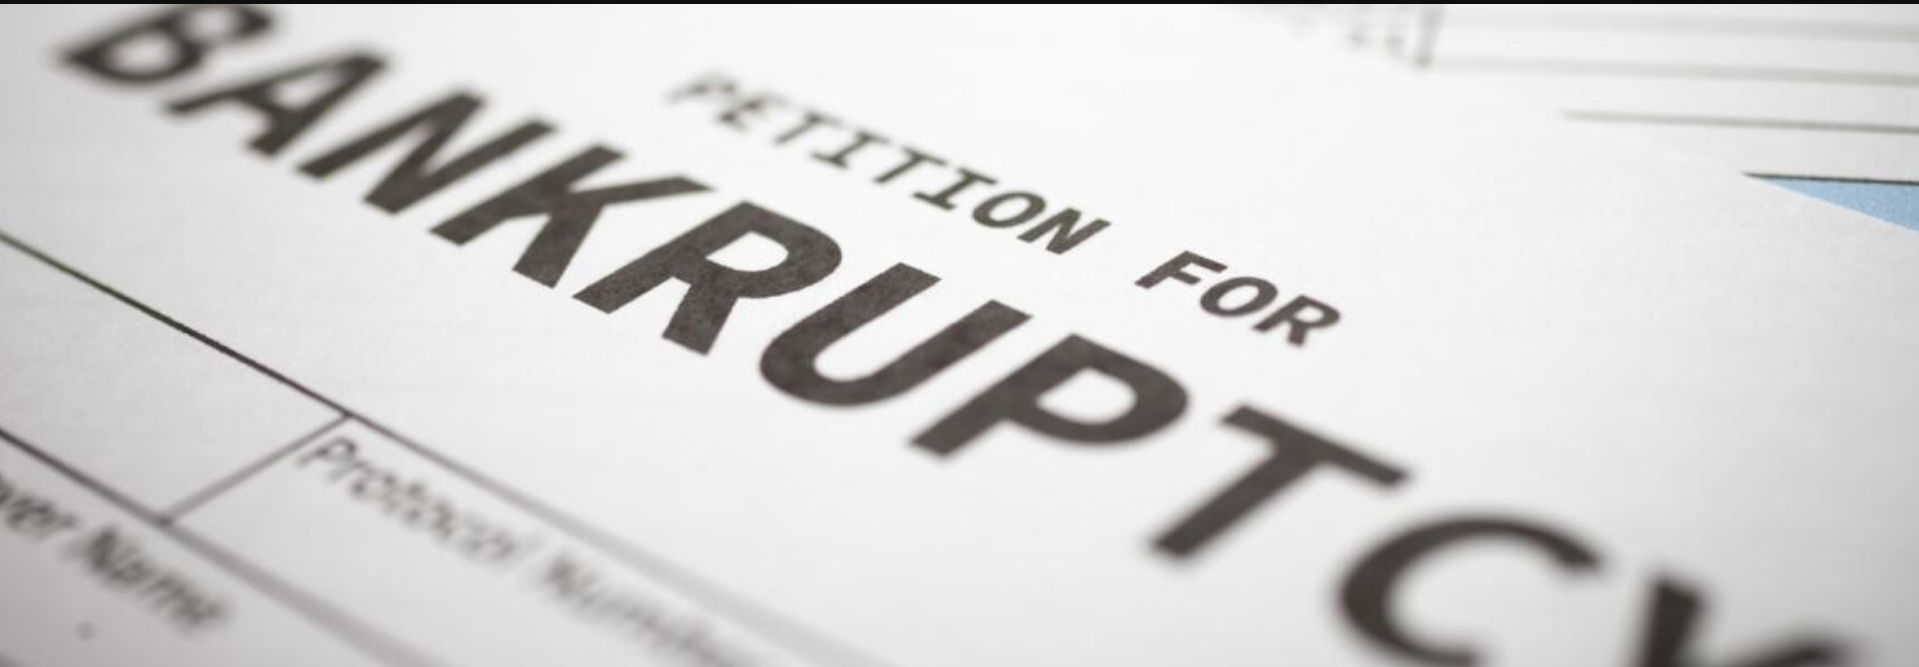

# Prediksi Risiko Kebangkrutan Perusahaan Taiwan Menggunakan Metode Klasifikasi sebagai Alat Bantu Pencegahan Kebangkrutan


Finansial yang tidak baik dapat menyebabkan kebangkrutan yang tidak hanya akan berpengaruh kepada pemilik dan karyawan, namun juga kepada investor dan kreditur secara keseluruhan. Kebangkrutan merupakan penutupan perusahaan atau disebut juga likuidasi, hal ini merupakan kondisi terjadinya kegagalan dalam masalah keuangan perusahaan yang tidak sebanding dengan jumlah asetnya (Nugroho & Rilvani, 2023).

Penelitian ini bertujuan untuk menghasilkan rancangan, mengimplementasikan, dan mengevaluasi solusi untuk masalah prediksi kebangkrutan perusahaan, khususnya prediksi Perusahaan di Taiwan. Dengan memanfaatkan data historis, machine learning menawarkan pendekatan yang kuat untuk mengenali pola-pola kompleks yang mungkin terlewat oleh analisis statistik.

# Informasi Dataset

Data yang digunakan dalam penelitian ini adalah dataset Taiwanese Bankruptcy Prediction yang bersumber dari UCI Machine Learning Repository. Dataset ini mencakup data keuangan dari perusahaan yang terdaftar di Taiwan Stock Exchange pada periode 1999 hingga 2009. Dataset terdiri dari 96 fitur rasio keuangan dan satu variabel target, di mana kelas '0' merepresentasikan perusahaan yang tidak bangkrut (sehat) dan kelas '1' merepresentasikan perusahaan yang bangkrut.

# Model Pipeline

Penelitian ini menerapkan alur kerja sistematis untuk memastikan validitas model, mematuhi batasan komputasi (maksimal 2.000 data), dan menghindari kebocoran data (data leakage).

# Alur Pipeline

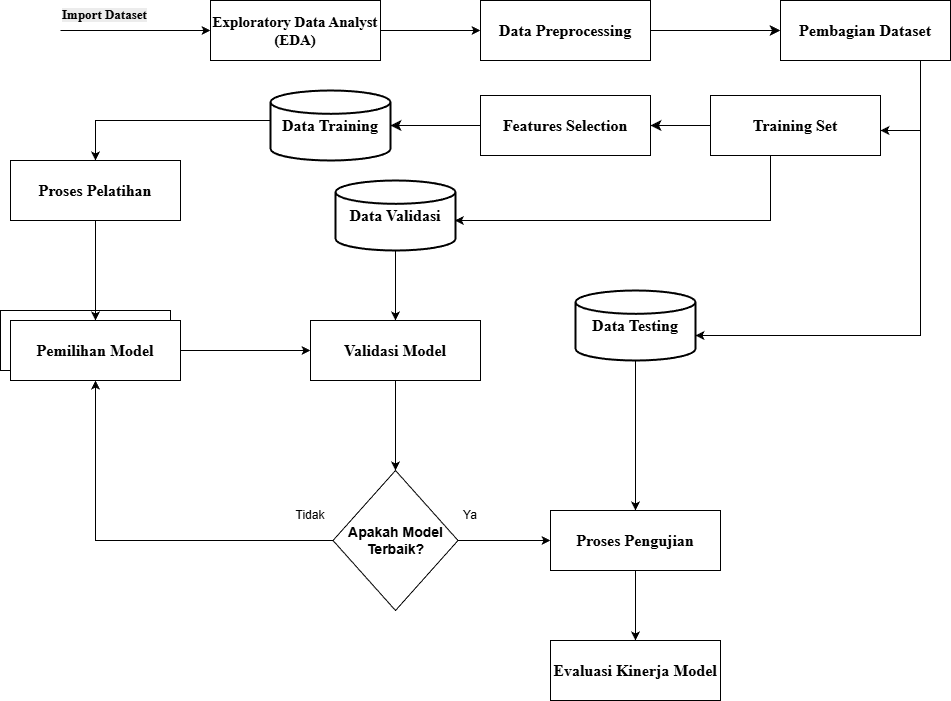

## Importing Package

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Library ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# Untuk Tuning Parameter
from sklearn.model_selection import GridSearchCV

# Untuk Menghitung Nilai/Skor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# (Opsional) Biar lengkap sekalian, pastikan ini juga ada:
from sklearn.metrics import classification_report, confusion_matrix

## Import Dataset

In [64]:
pip install ucimlrepo

In [66]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

# data (as pandas dataframes)
X = taiwanese_bankruptcy_prediction.data.features
y = taiwanese_bankruptcy_prediction.data.targets

# metadata
print(taiwanese_bankruptcy_prediction.metadata)

# variable information
print(taiwanese_bankruptcy_prediction.variables)

df = pd.concat([X, y], axis=1)

{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

### Exploratory Data Analyst



## Melihat Informasi Data



In [67]:
TARGET_COLUMN = 'Bankrupt?'
print(f"Target Variable: {TARGET_COLUMN}")
print("Jumlah baris: ",df.shape[0])
print("Jumlah kolom: ",df.shape[1])
print("Jumlah Kolom per Tipe Data")
display(df.dtypes.value_counts())

Target Variable: Bankrupt?
Jumlah baris:  6819
Jumlah kolom:  96
Jumlah Kolom per Tipe Data


float64    93
int64       3
Name: count, dtype: int64

## Cek Target (Bangkrupt)

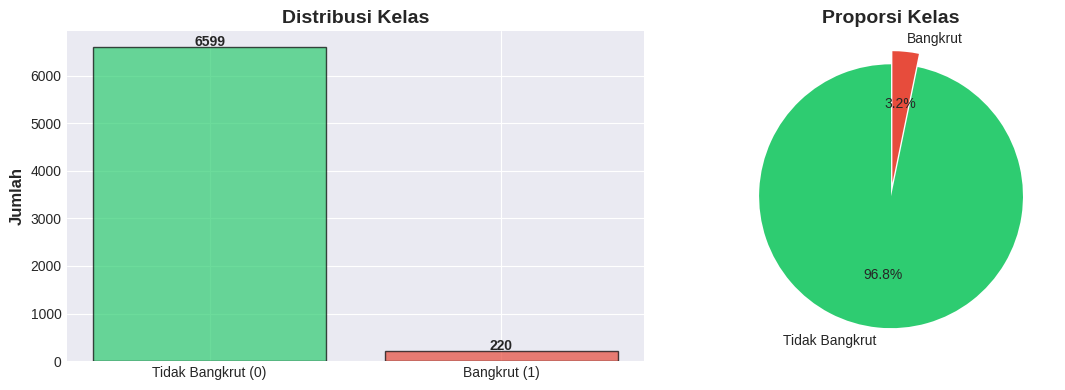

Rasio Imbalance: 1:29


In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
counts = df["Bankrupt?"].value_counts()
ax1.bar(['Tidak Bangkrut (0)', 'Bangkrut (1)'], counts.values,
        color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Jumlah', fontsize=12, fontweight='bold')
ax1.set_title('Distribusi Kelas', fontsize=14, fontweight='bold')
for i, v in enumerate(counts.values):
    ax1.text(i, v + 20, str(v), ha='center', fontweight='bold')

# Pie chart
ax2.pie(counts.values, labels=['Tidak Bangkrut', 'Bangkrut'],
        autopct='%1.1f%%', startangle=90,
        colors=['#2ecc71', '#e74c3c'], explode=(0, 0.1))
ax2.set_title('Proporsi Kelas', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Rasio Imbalance: 1:{counts.iloc[0]//counts.iloc[1]}")

Pada class positif (1) menandakan bahwa perusahaan bankrupt. Perusahaan yang diprediksi dan diberi label bankrupt ada sebanyak 220 perusahaan. Sedangkan class negatif (0) adalah perusahaan yang tidak bankrupt. Perusahaan tidak bankrupt ada sebanyak 6599.

Dalam visualisasi di atas, terlihat bahwa terjadi imbalance data antara perusahaan yang berlabel bankrupt dan tidak bankrupt. Imbalance data akan membuat model hanya berfokus terhadap data mayoritas. Maka dari itu, harus dilakukan penanganan untuk masalah imbalance data dalam dataset ini.

## Cek Missing Value dan Data Duplikat

In [69]:
print(f"Missing Values: {df.isnull().sum().sum()}")

Missing Values: 0


In [70]:
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

Jumlah data duplikat: 0


## Cek Outlier

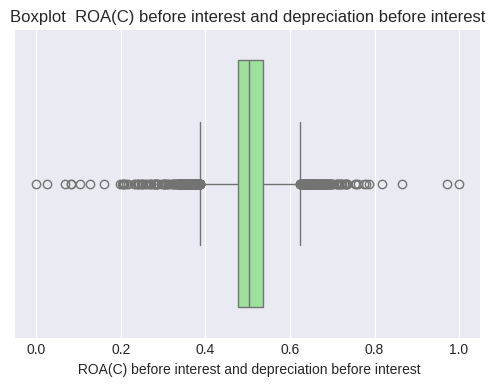

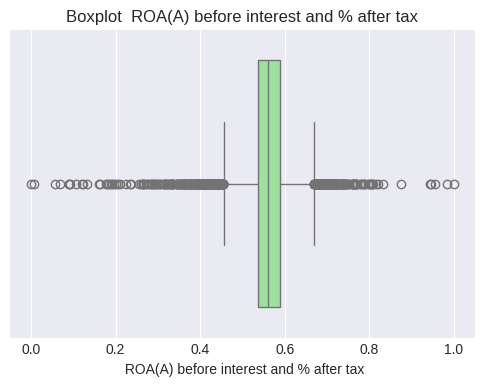

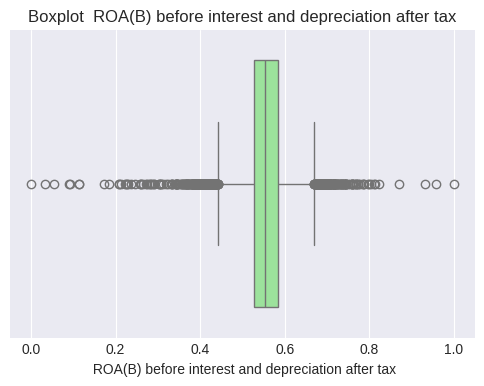

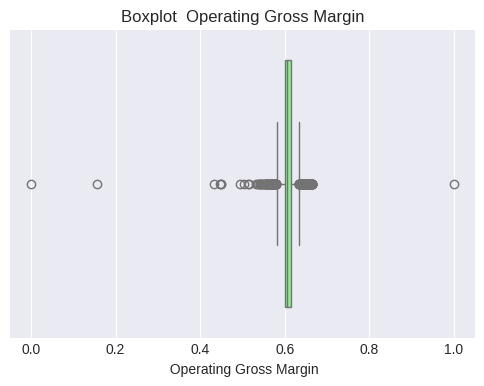

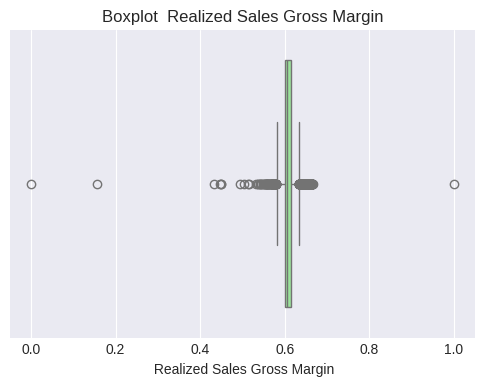

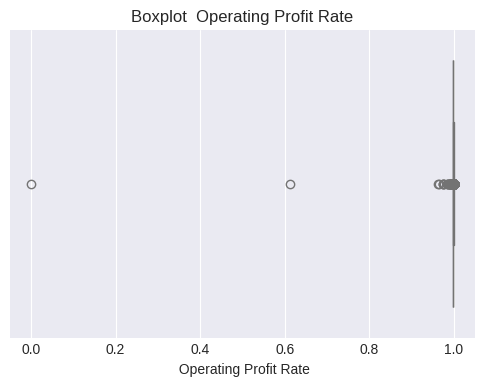

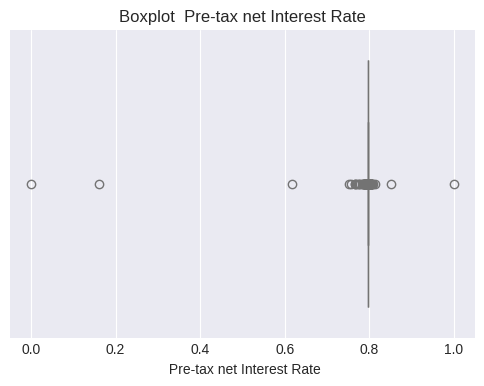

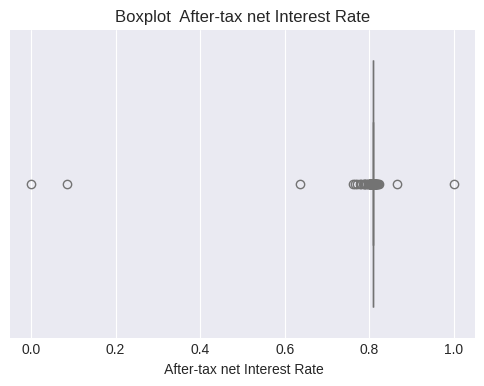

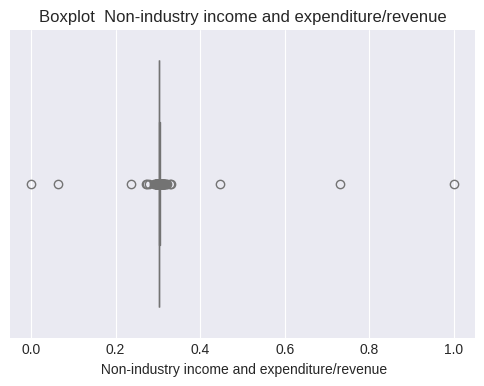

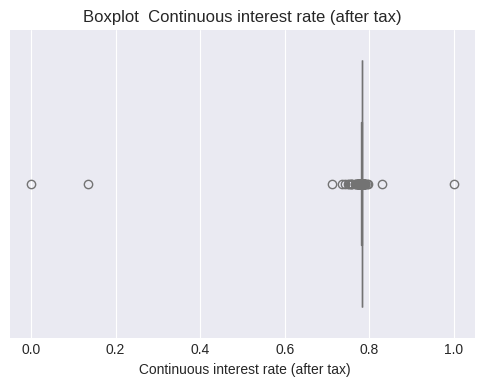

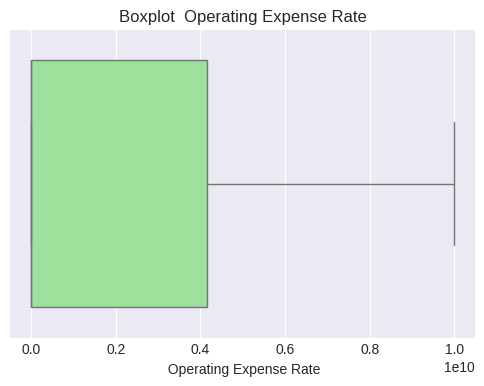

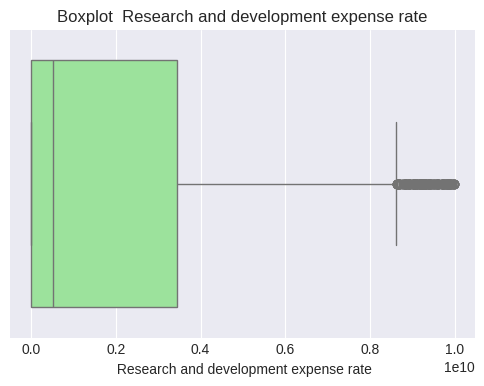

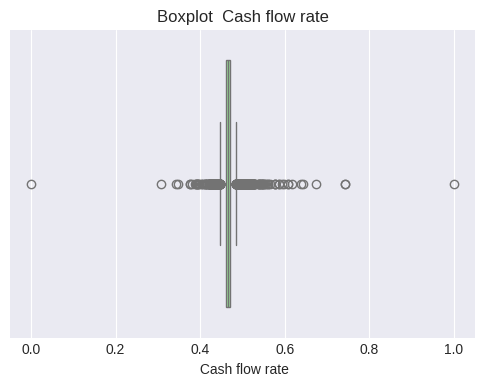

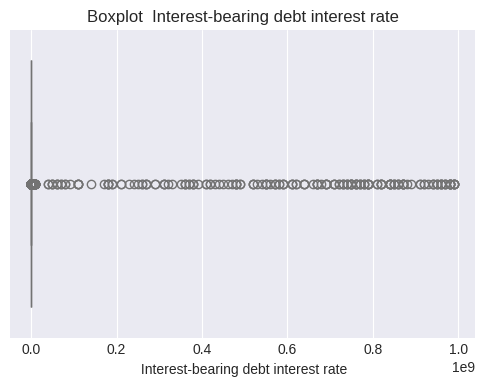

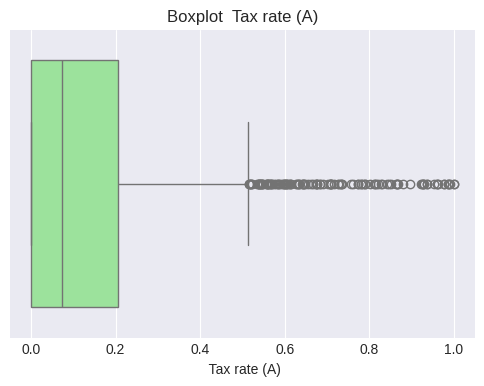

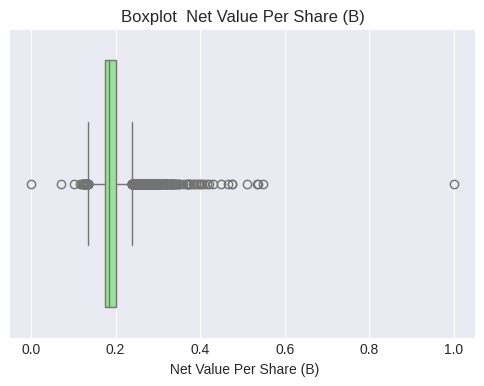

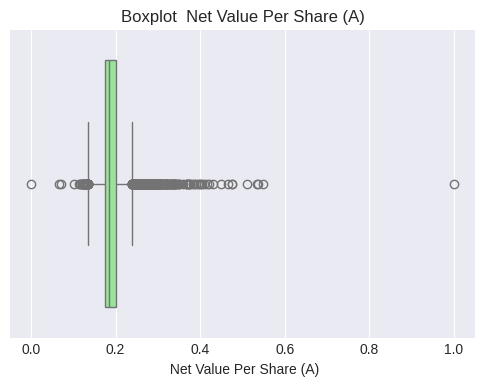

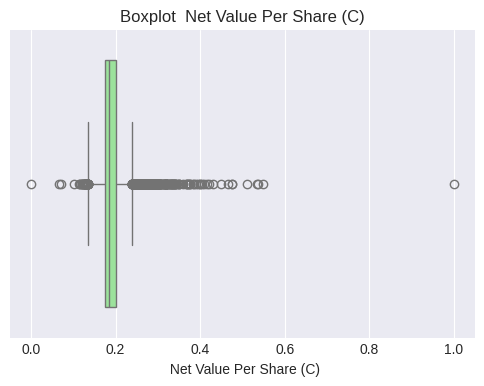

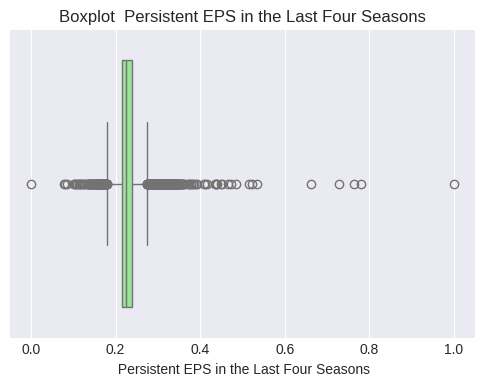

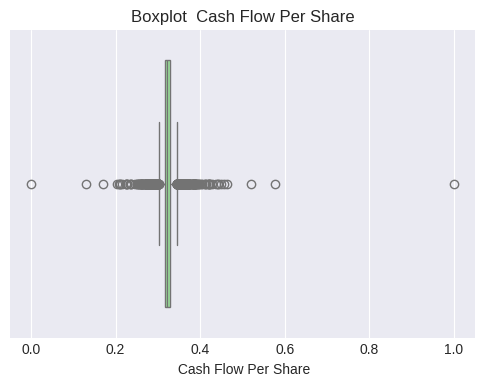

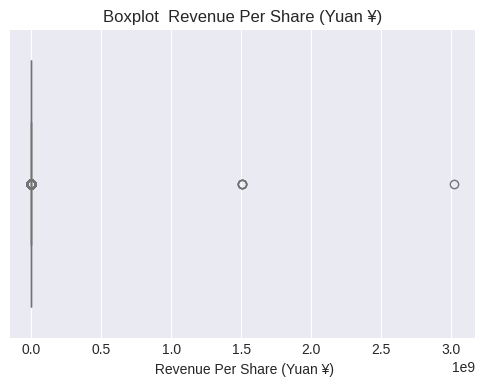

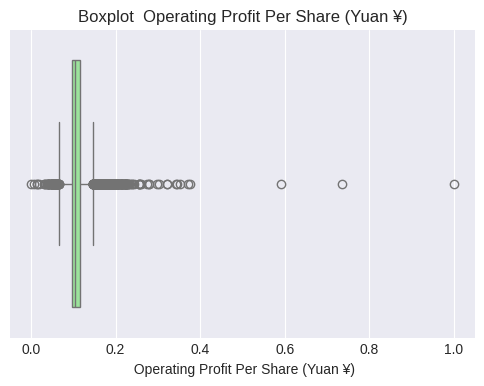

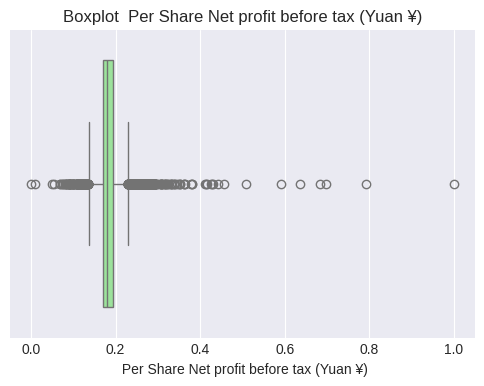

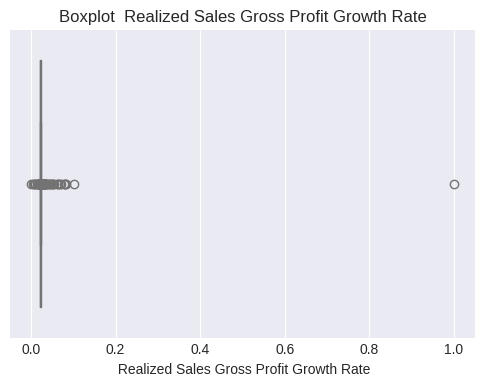

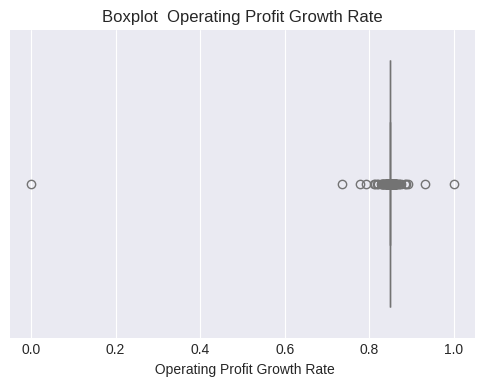

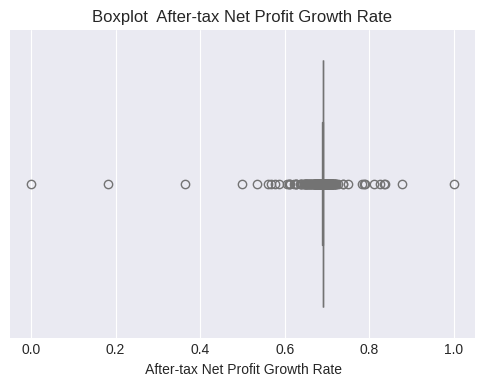

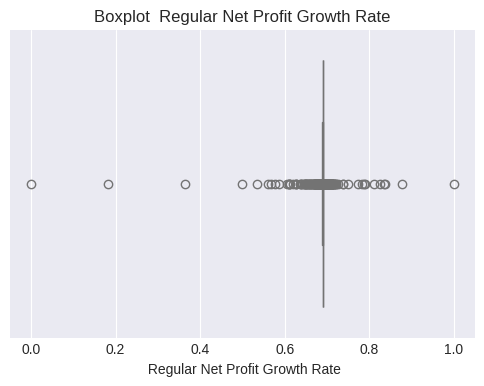

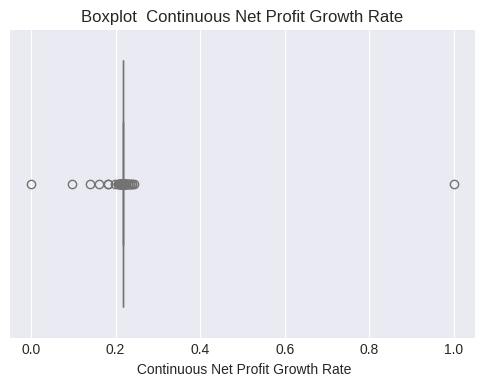

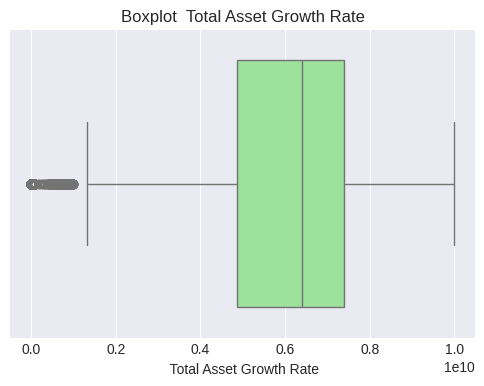

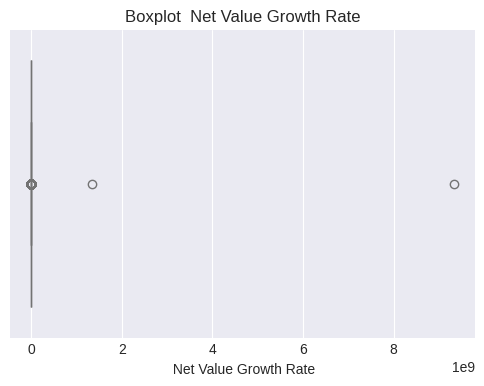

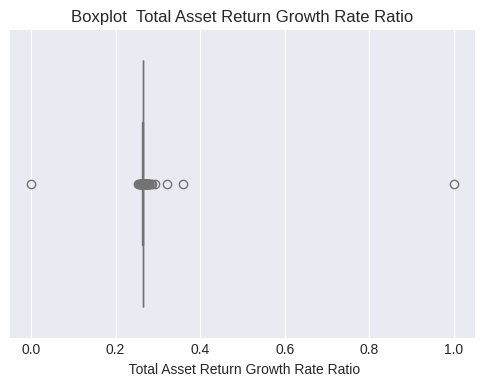

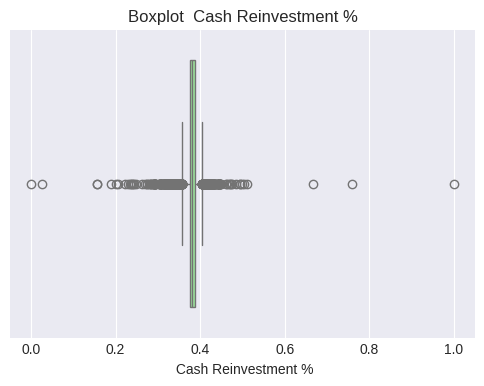

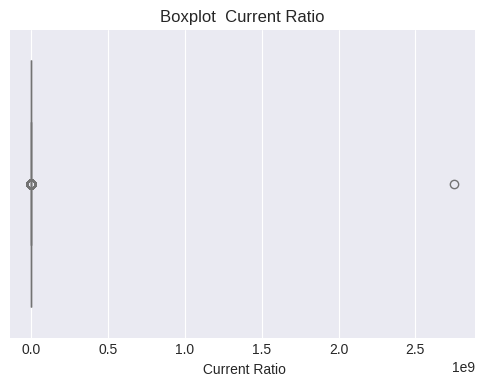

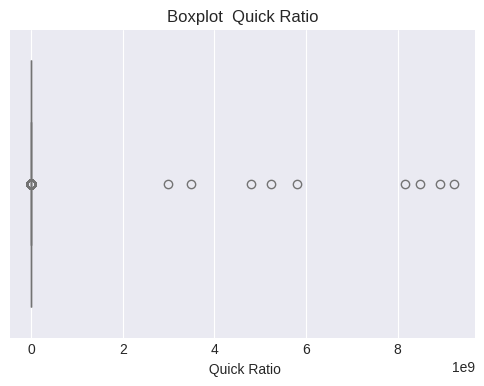

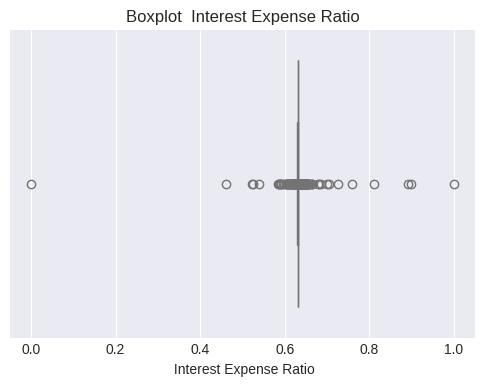

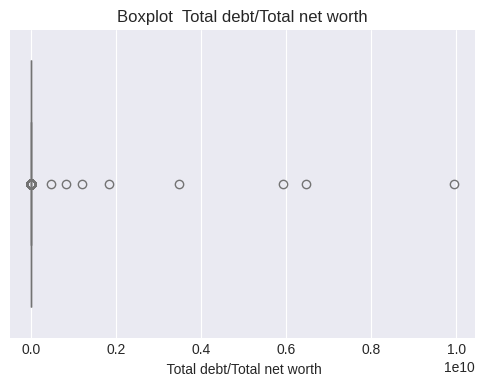

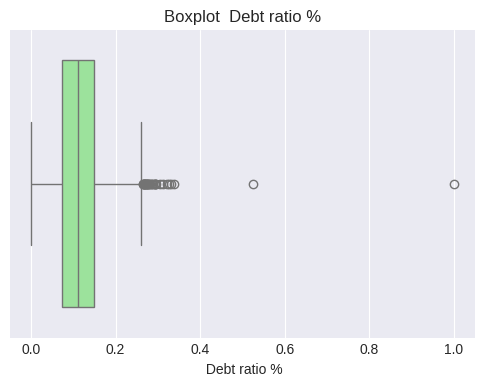

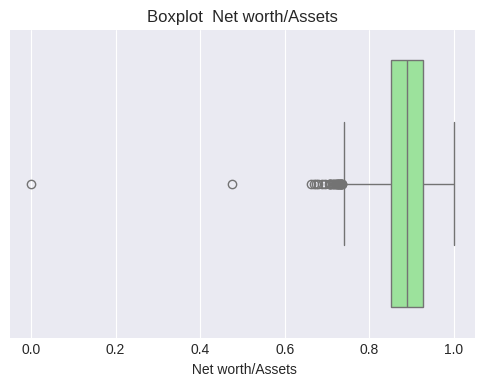

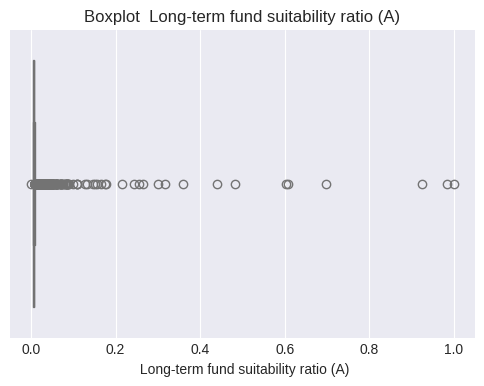

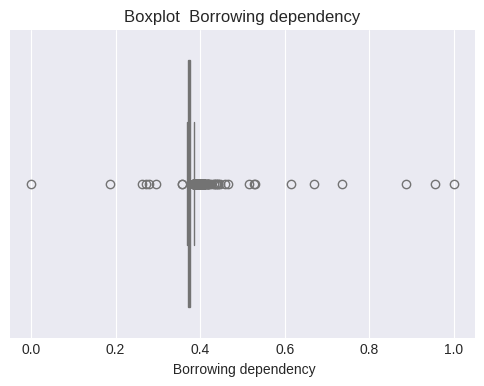

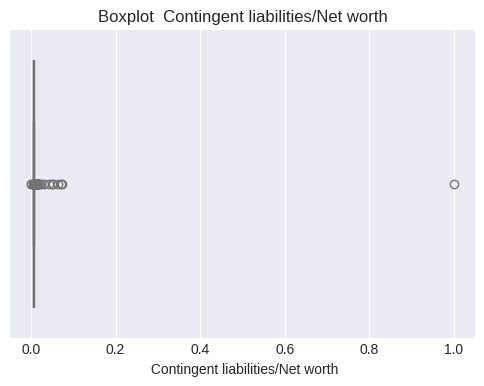

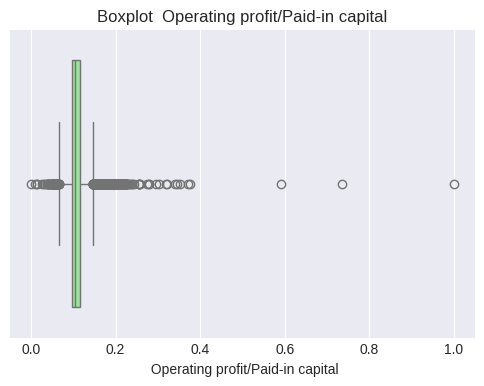

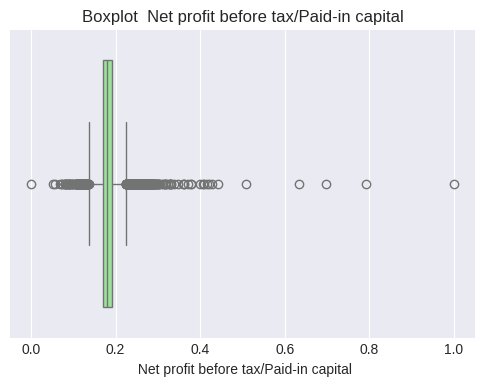

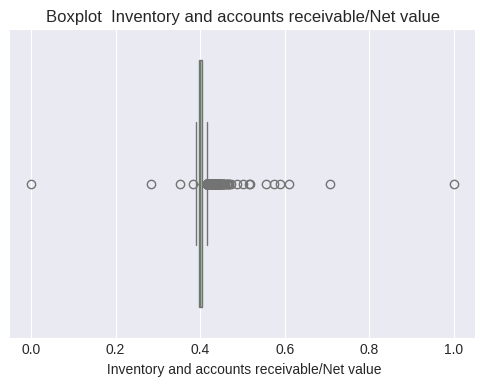

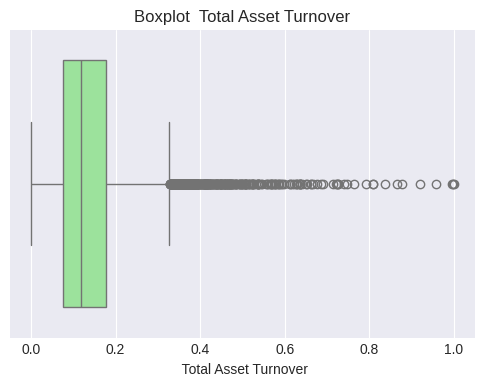

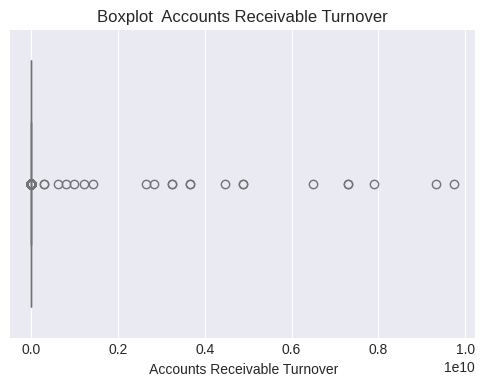

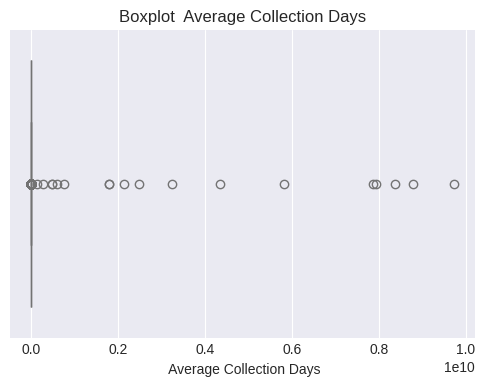

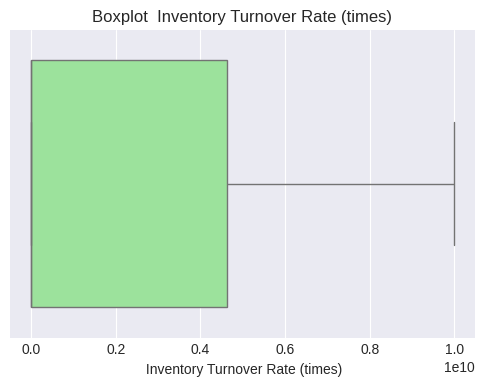

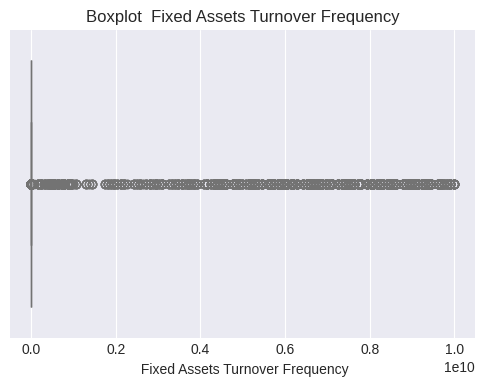

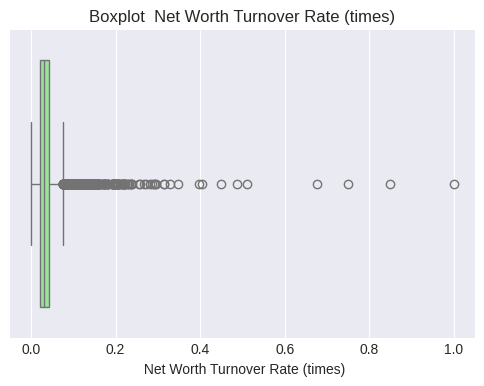

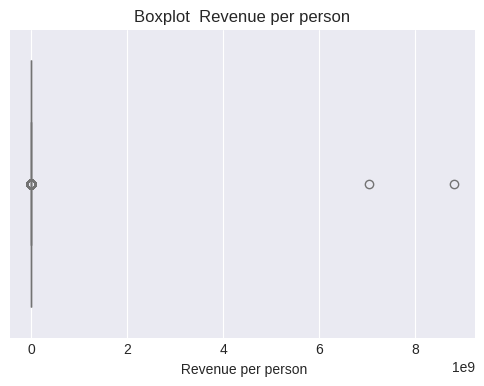

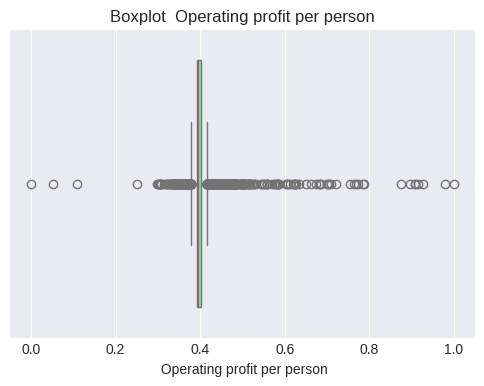

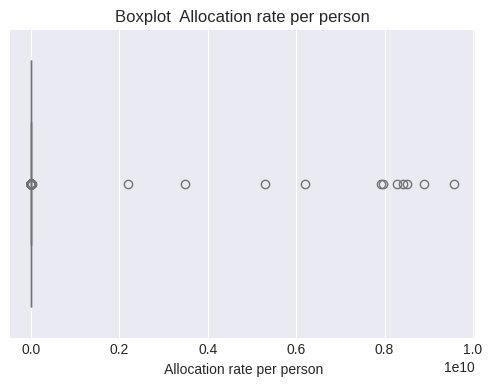

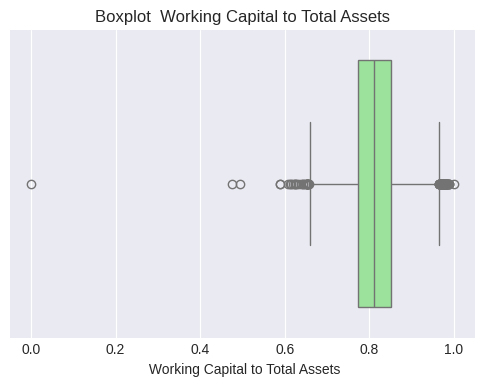

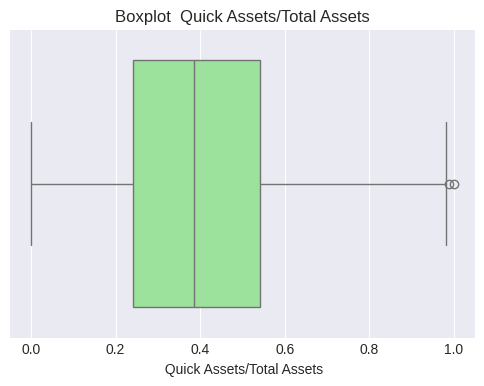

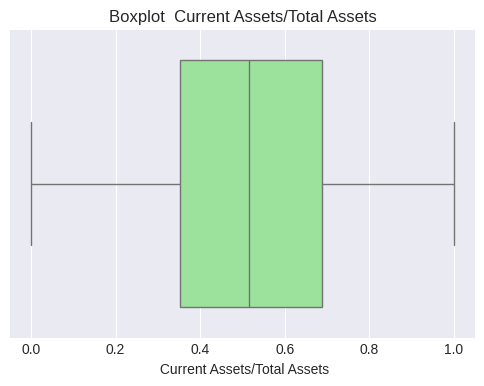

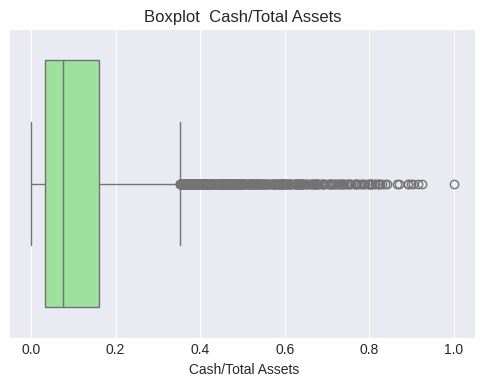

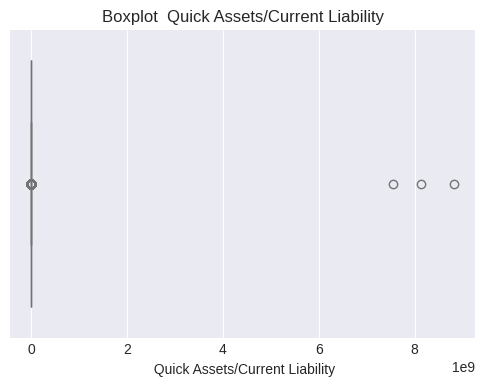

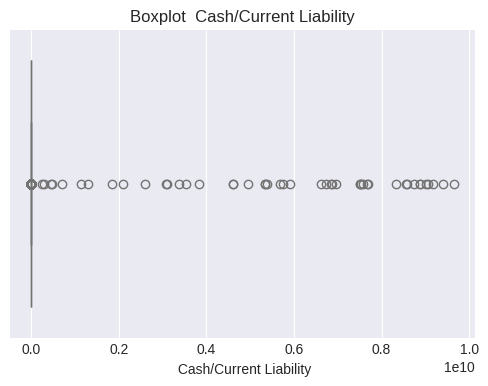

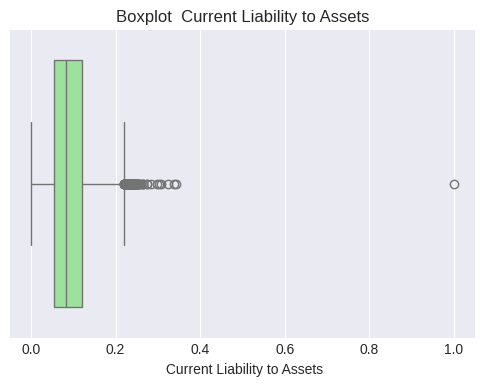

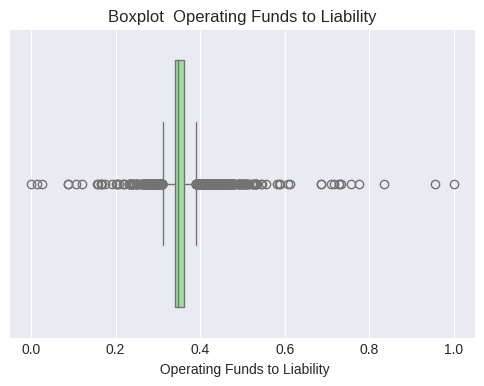

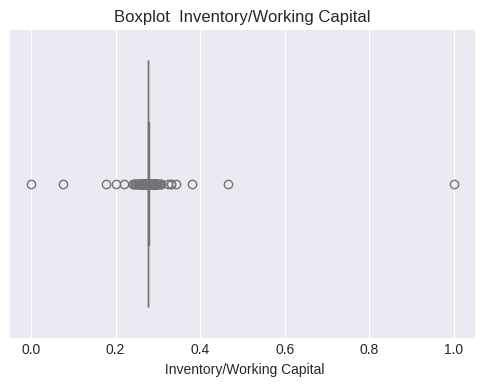

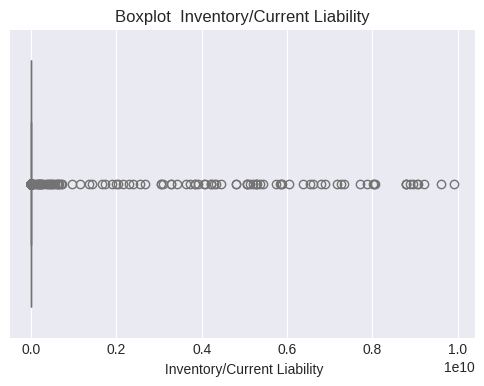

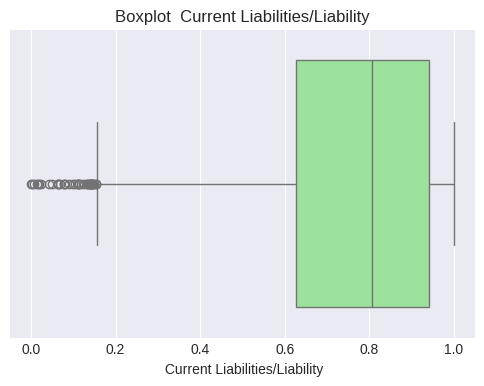

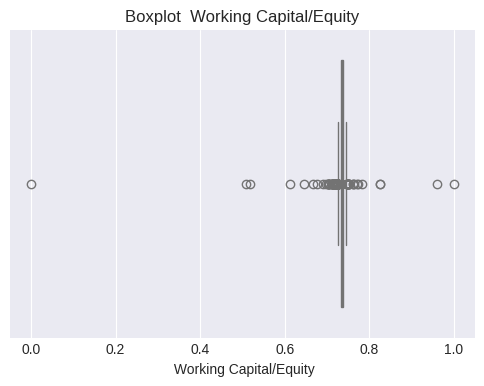

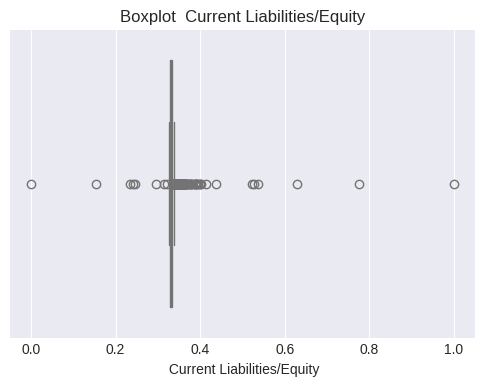

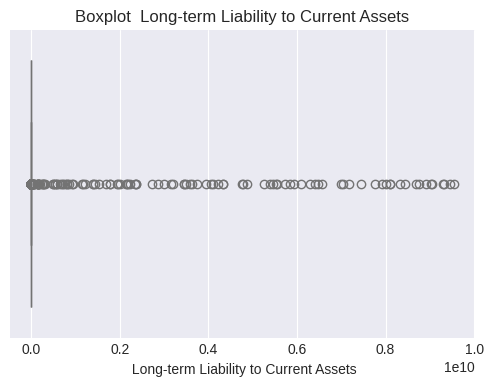

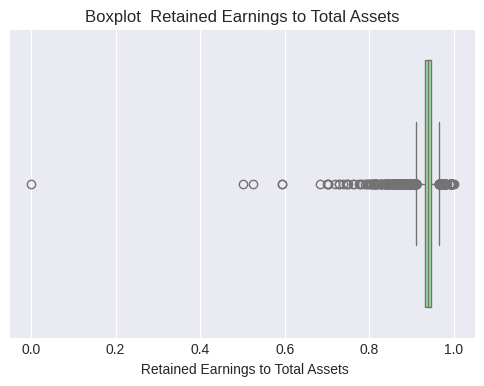

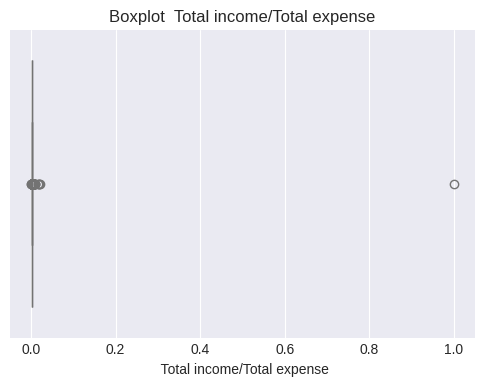

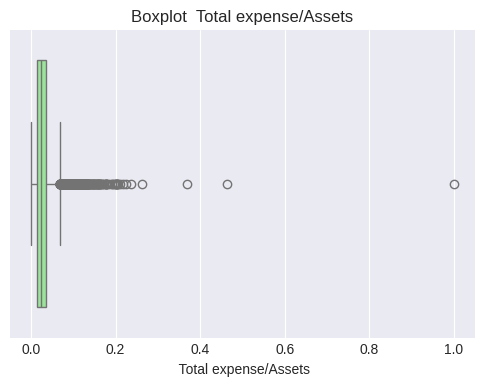

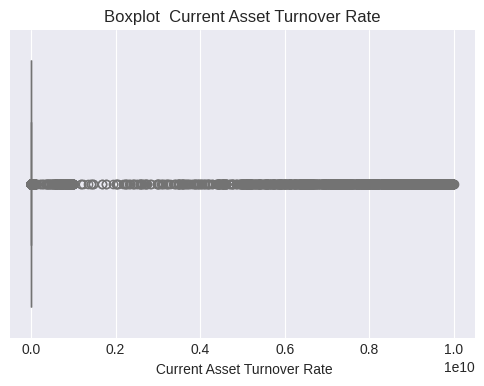

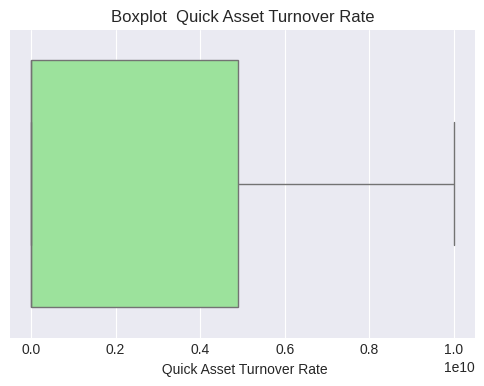

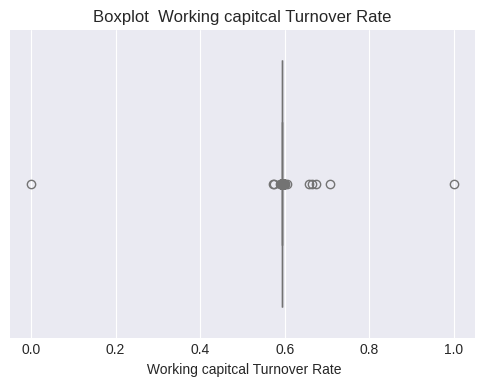

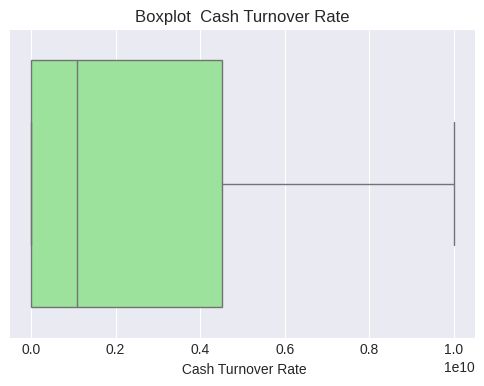

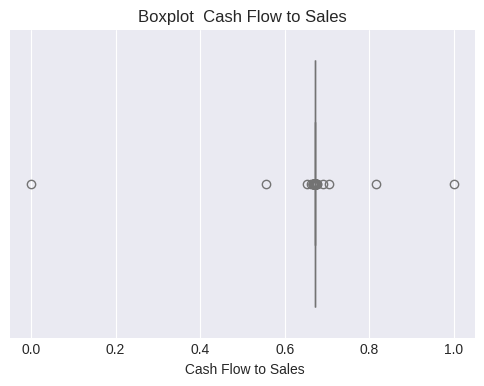

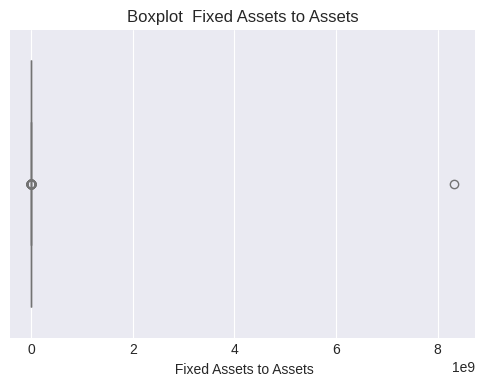

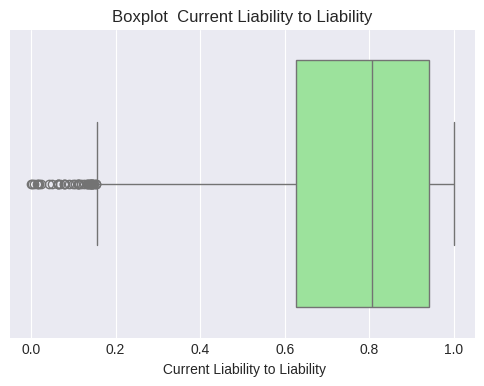

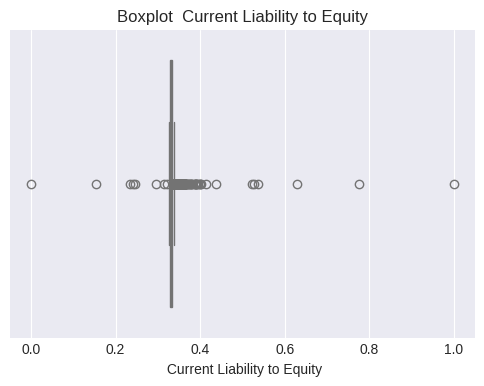

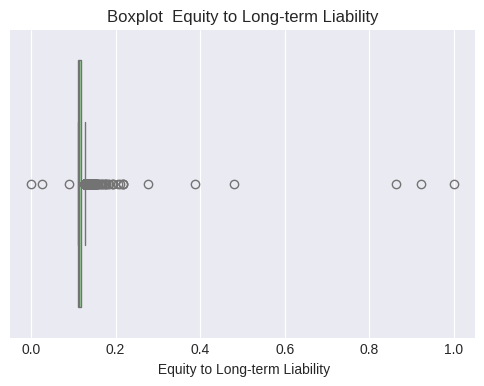

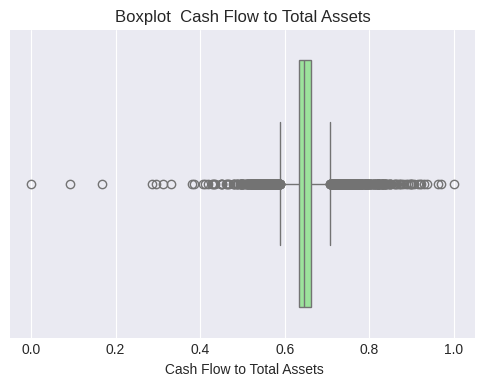

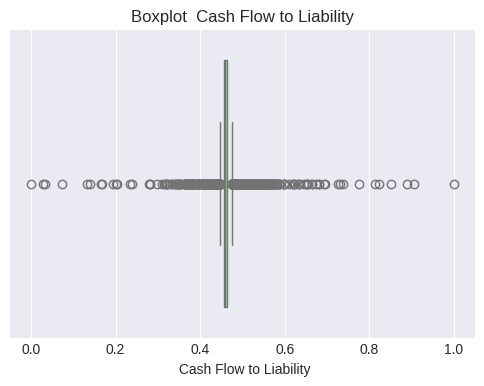

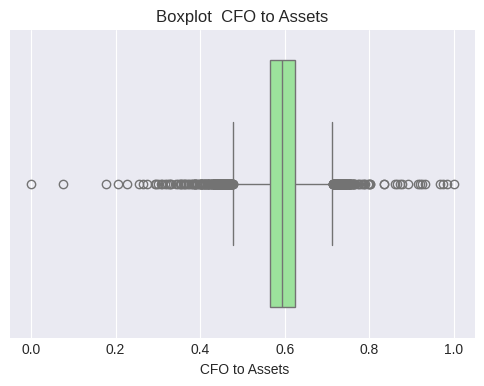

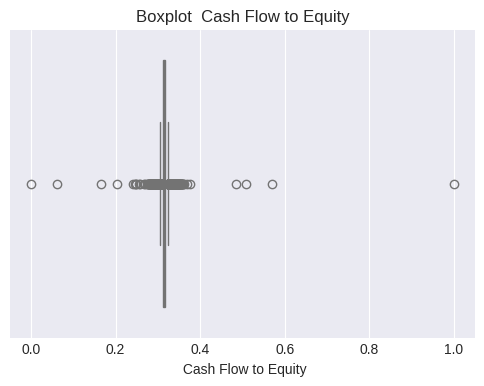

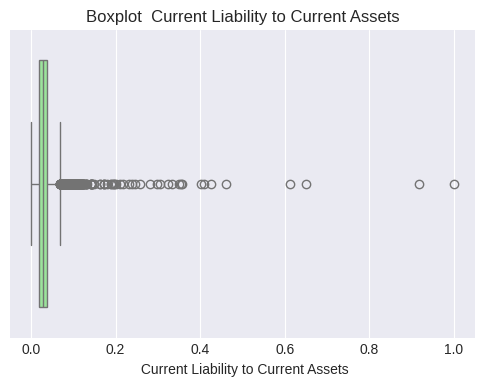

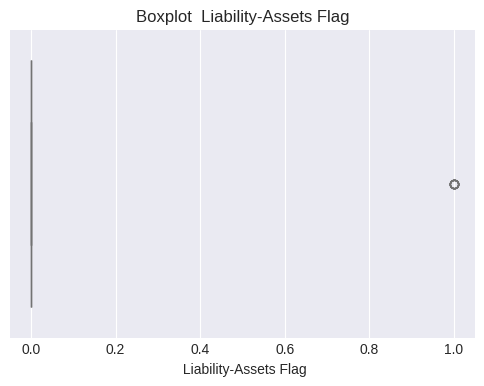

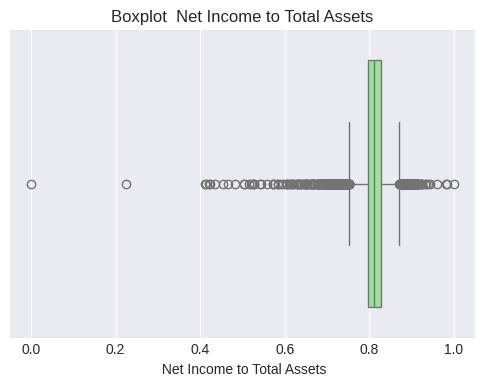

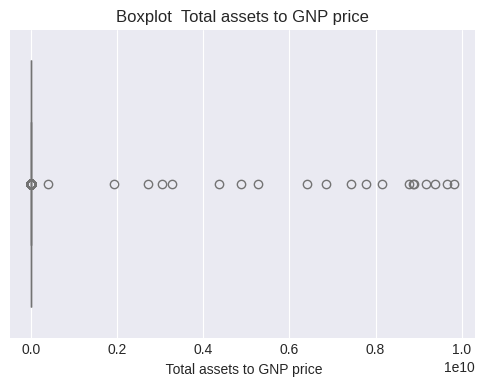

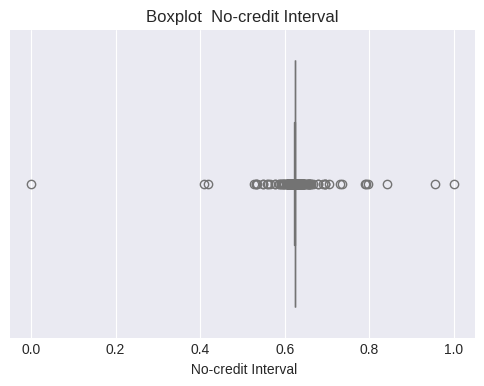

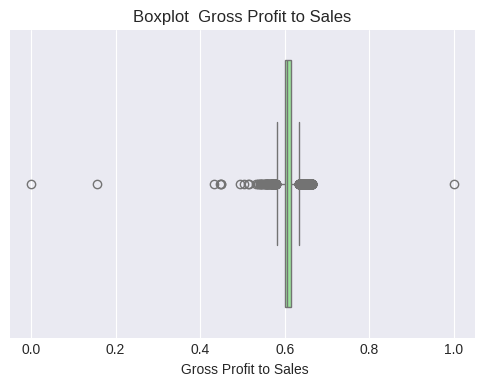

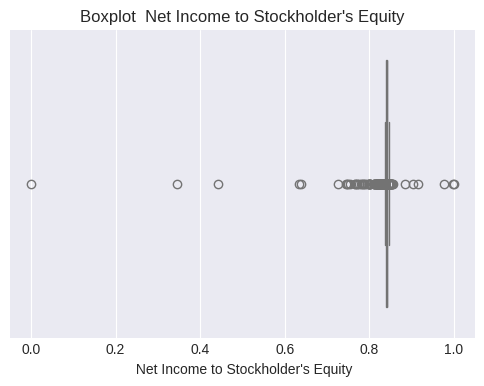

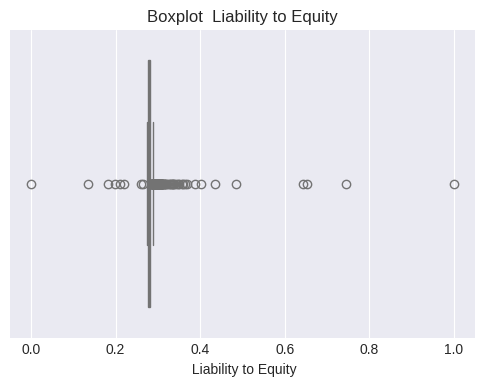

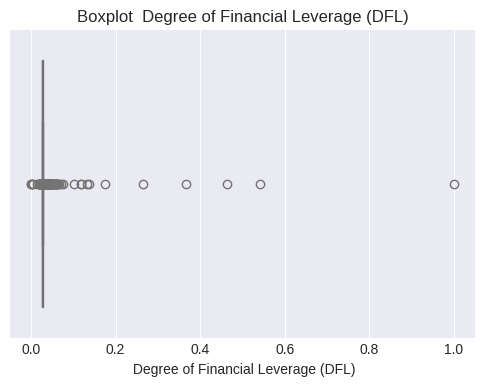

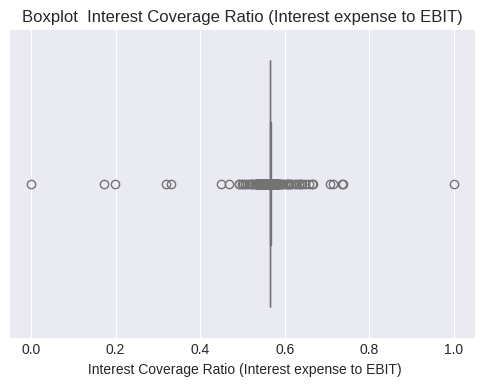

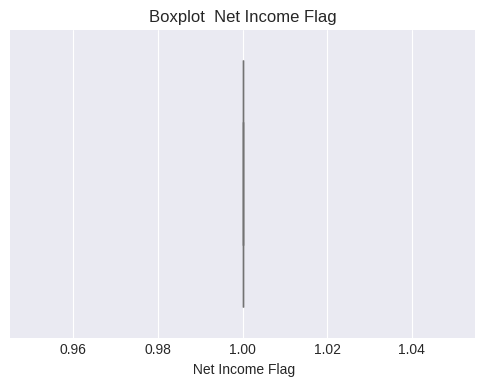

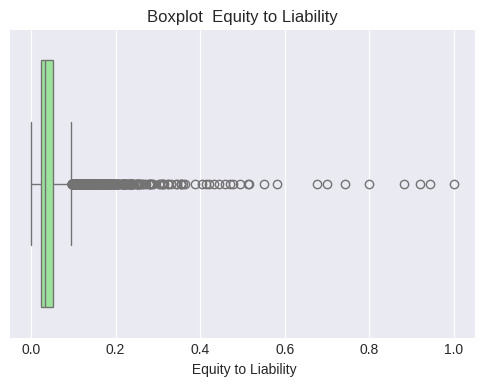

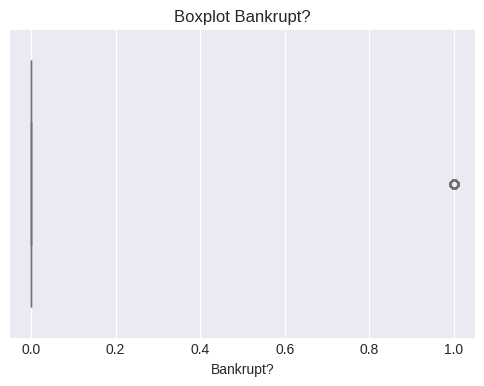

In [72]:
#Cek outlier dengan menggunakan boxplot
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color="lightgreen")
    plt.title(f"Boxplot {col}")
    plt.show()

In [73]:
df.describe().T[['min','max']].head(20)

min           max
ROA(C) before interest and depreciation before ...  0.0  1.000000e+00
ROA(A) before interest and % after tax              0.0  1.000000e+00
ROA(B) before interest and depreciation after tax   0.0  1.000000e+00
Operating Gross Margin                              0.0  1.000000e+00
Realized Sales Gross Margin                         0.0  1.000000e+00
Operating Profit Rate                               0.0  1.000000e+00
Pre-tax net Interest Rate                           0.0  1.000000e+00
After-tax net Interest Rate                         0.0  1.000000e+00
Non-industry income and expenditure/revenue         0.0  1.000000e+00
Continuous interest rate (after tax)                0.0  1.000000e+00
Operating Expense Rate                              0.0  9.990000e+09
Research and development expense rate               0.0  9.980000e+09
Cash flow rate                                      0.0  1.000000e+00
Interest-bearing debt interest rate                 0.0  9.900000e+08
Tax rate (A)                                        0.0  1.000000e+00
Net Value Per Share (B)                             0.0  1.000000e+00
Net Value Per Share (A)                             0.0  1.000000e+00
Net Value Per Share (C)                             0.0  1.000000e+00
Persistent EPS in the Last Four Seasons             0.0  1.000000e+00
Cash Flow Per Share                                 0.0  1.000000e+00

Terdapat beberapa feature yang memiliki outlier extrem. Beberapa fitur nantinya akan dinormalisasi untuk menyamakan skala model.

### Kesimpulan Exploratory Data Analysis (EDA)

1.   Terjadi imbalance data antara label bankrupt dan tidak bankrupt sehingga harus ada handle untuk mengatasi imbalance tersebut.
2.   Features selection akan dilakukan karena dataset ini memiliki 96 feature yang dimana terdapat beberapa features yang memiliki makna yang sama.
3. Tidak ada missing value dan data duplikat.
4. Skala antar fitur berbeda-beda sehingga perlu dipertimbangkan normalisasi/scaling sesuai algoritma yang digunakan.

## Data Preprocessing

   Master Dataset: 2000 data


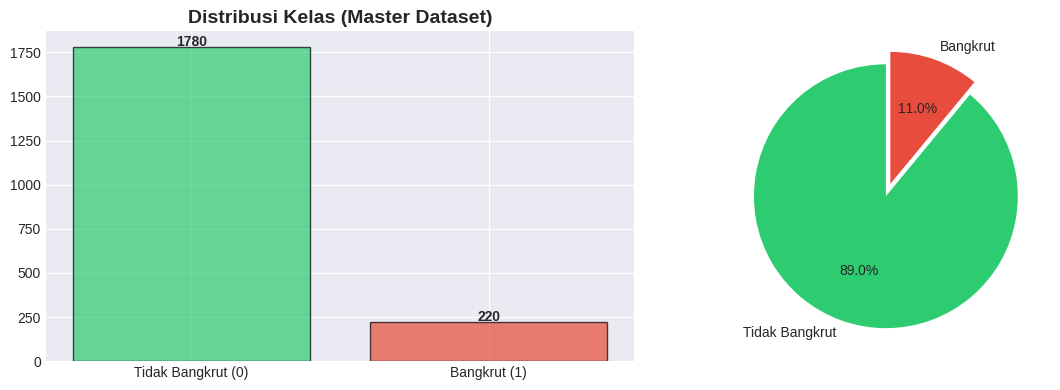

In [74]:
df_bangkrut = df[df[TARGET_COLUMN] == 1]
df_sehat = df[df[TARGET_COLUMN] == 0]
df_sehat_sampled = df_sehat.sample(n=1780, random_state=42)
df_master = pd.concat([df_sehat_sampled, df_bangkrut]).sample(frac=1, random_state=42)

X = df_master.drop(TARGET_COLUMN, axis=1)
y = df_master[TARGET_COLUMN]

print(f"   Master Dataset: {len(X)} data")

# VISUALISASI DISTRIBUSI KELAS (MASTER DATA)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
counts_master = y.value_counts()

ax1.bar(['Tidak Bangkrut (0)', 'Bangkrut (1)'], counts_master.values,
        color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax1.set_title("Distribusi Kelas (Master Dataset)", fontsize=14, fontweight='bold')
for i, v in enumerate(counts_master.values):
    ax1.text(i, v + 5, str(v), ha='center', fontweight='bold')

ax2.pie(counts_master.values, labels=['Tidak Bangkrut', 'Bangkrut'],
        autopct='%1.1f%%', startangle=90,
        colors=['#2ecc71', '#e74c3c'], explode=(0, 0.1))
plt.tight_layout()
plt.show()

## Pembagian Dataset

In [75]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/9, random_state=42, stratify=y_temp
)

print(f"   Train Set: {X_train.shape}")
print(f"   Validation Set: {X_val.shape}")
print(f"   Test Set: {X_test.shape}")

   Train Set: (1600, 95)
   Validation Set: (200, 95)
   Test Set: (200, 95)


Pembagian dataset ini menggunakan teknik Hold-out method dengan rasio 80%:10%:10%, yaitu 80% untuk data latih serta 10% untuk data uji dan 10% untuk data validasi. Keuntungan menggunakan metode ini adalah mudah dilakukan, dan kelemahannya adalah model hanya diuji pada satu bagian data, yang mungkin tidak cukup representatif.


## Data Preprocessing - Train Set

In [76]:
# OUTLIER HANDLING
features_numeric = X_train.select_dtypes(include=[np.number]).columns
for column in features_numeric:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lowerL = Q1 - 1.5 * IQR
    higherL = Q3 + 1.5 * IQR

    X_train.loc[X_train[column] < lowerL, column] = lowerL
    X_train.loc[X_train[column] > higherL, column] = higherL

print("   ✅ Outlier handling (IQR capping) selesai pada Train Set")

# SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_df = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
print("   ✅ Standardization (StandardScaler) selesai")

   ✅ Outlier handling (IQR capping) selesai pada Train Set
   ✅ Standardization (StandardScaler) selesai


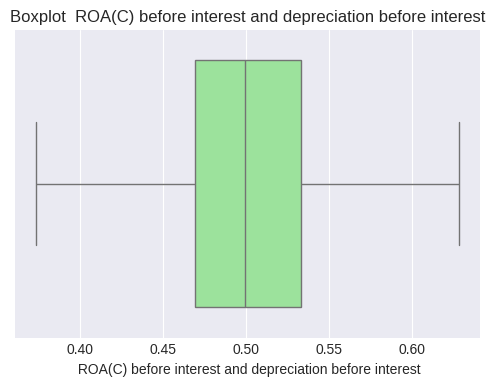

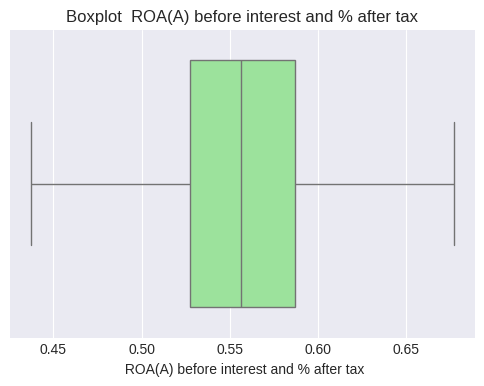

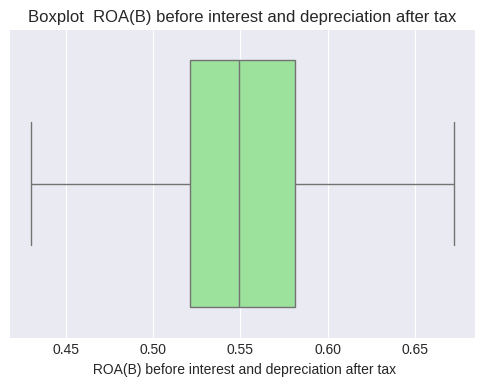

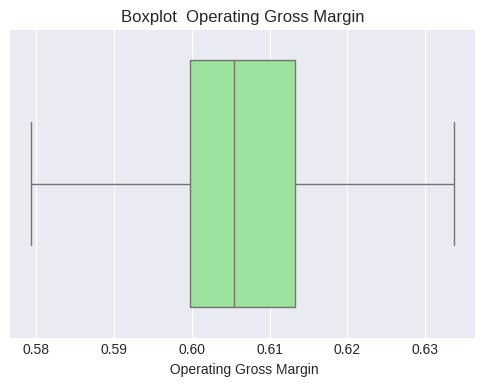

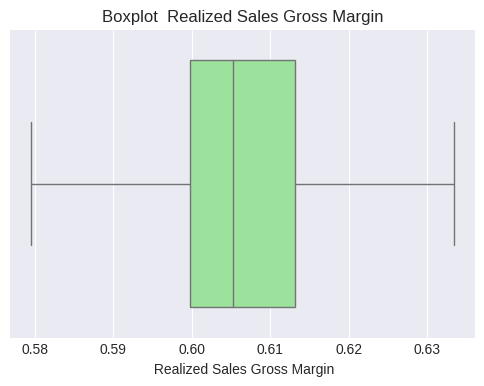

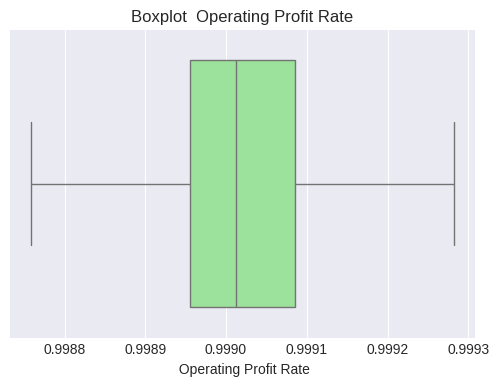

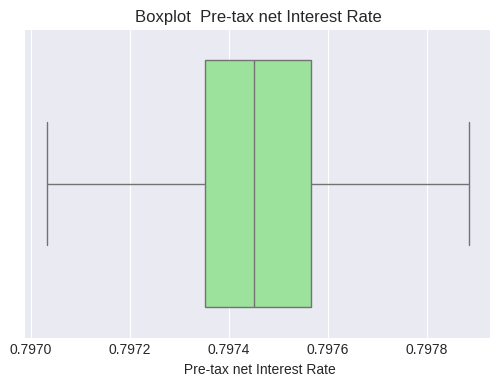

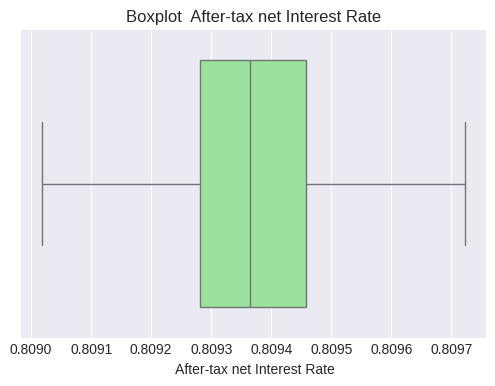

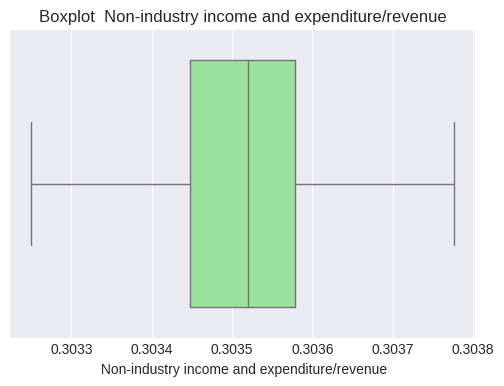

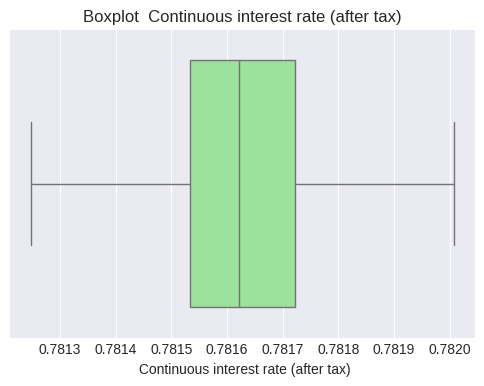

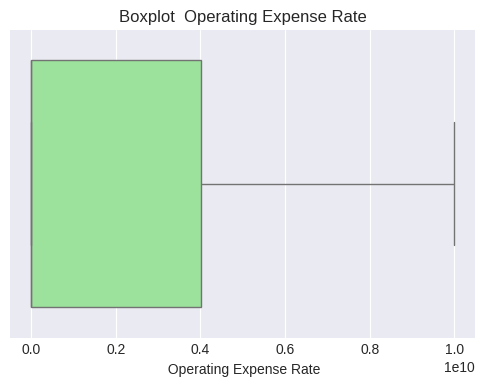

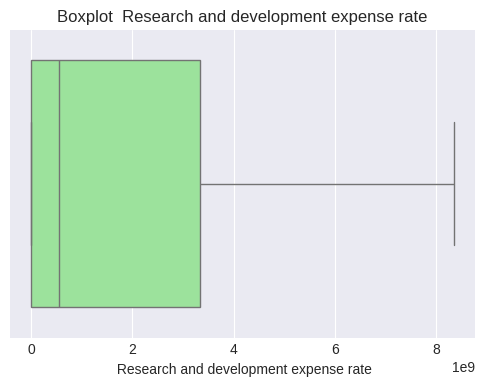

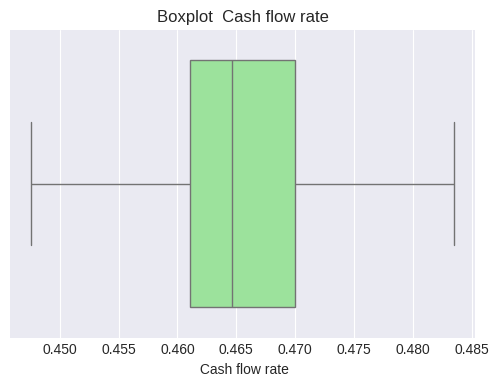

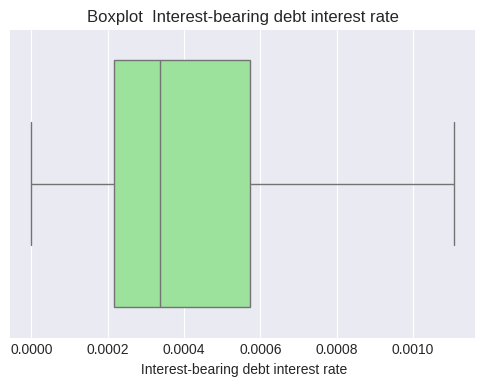

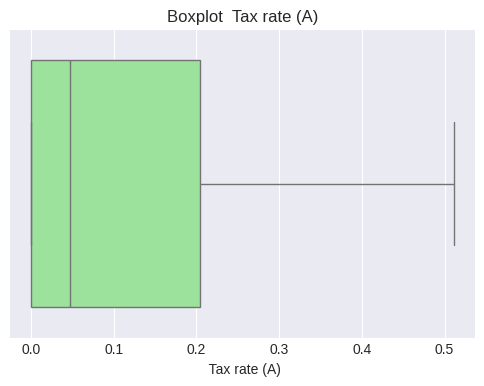

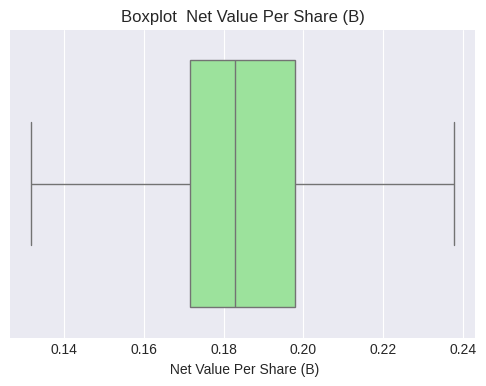

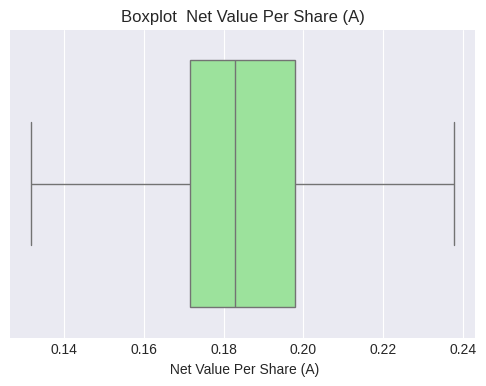

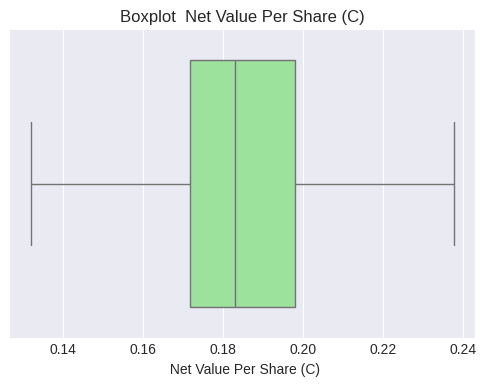

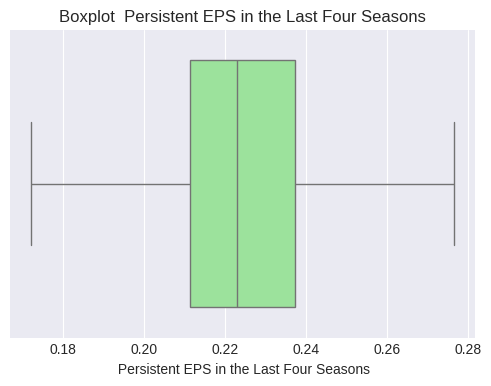

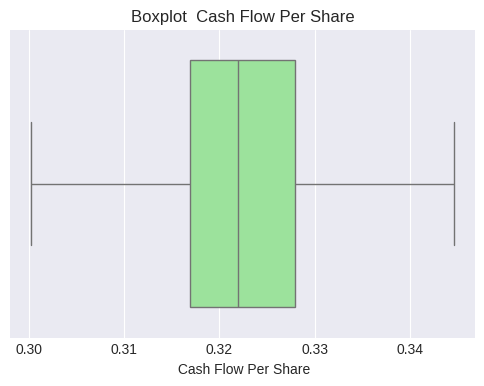

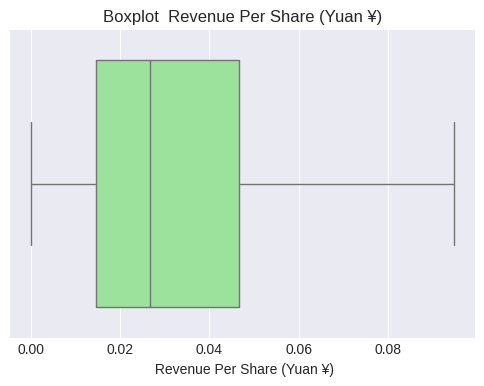

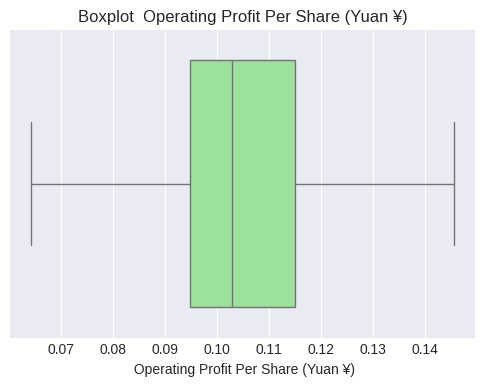

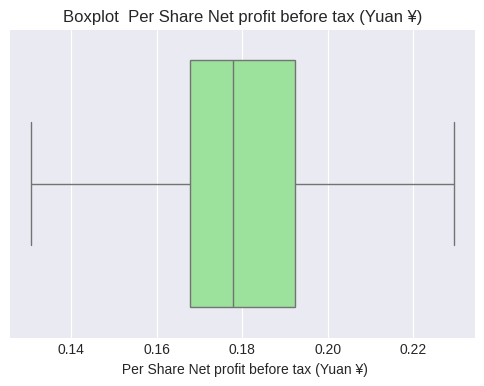

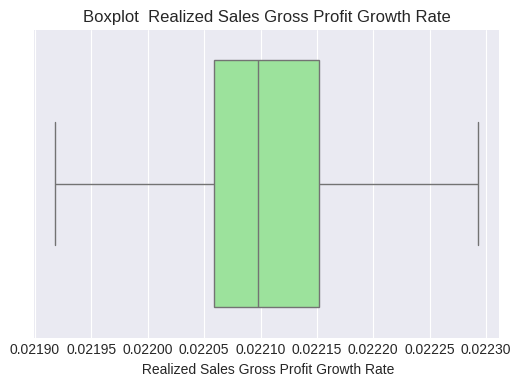

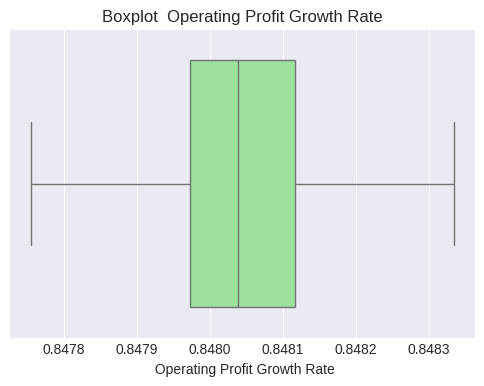

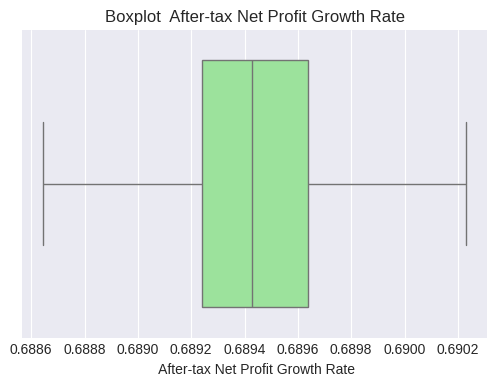

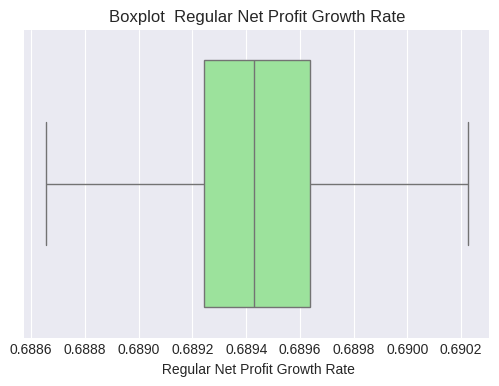

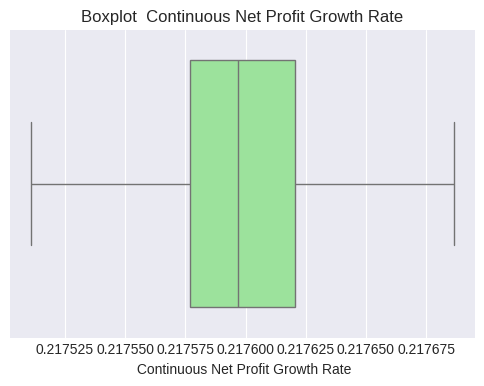

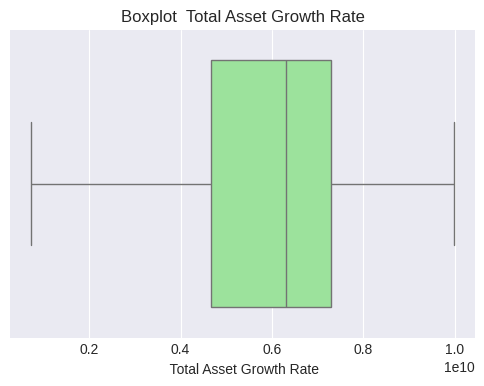

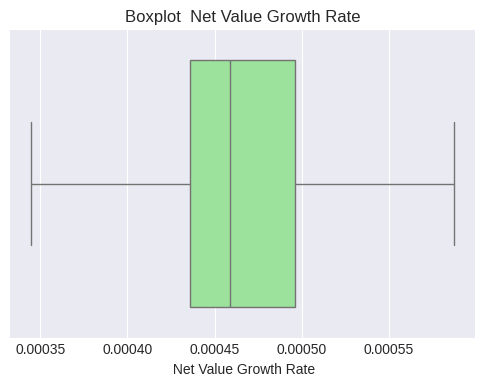

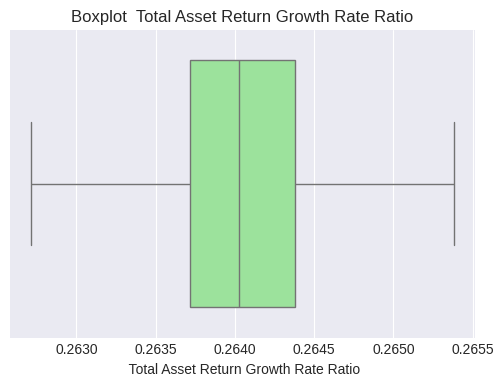

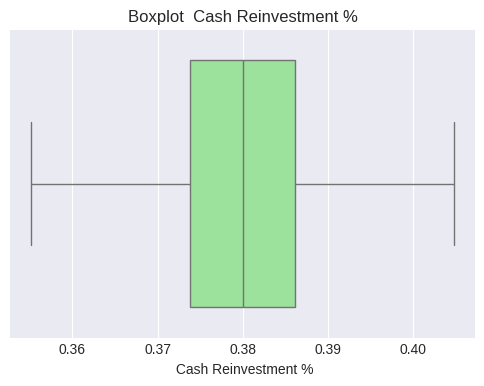

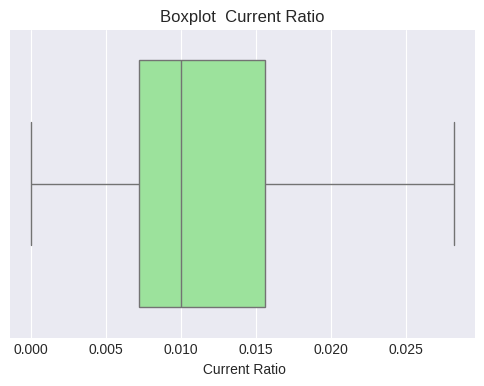

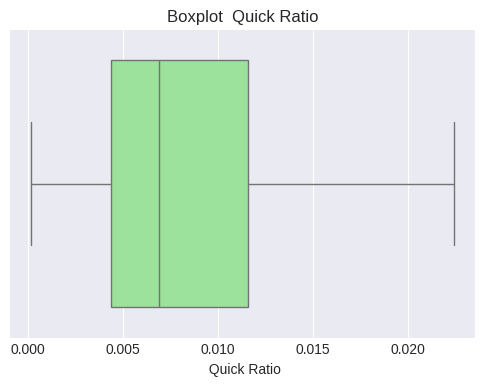

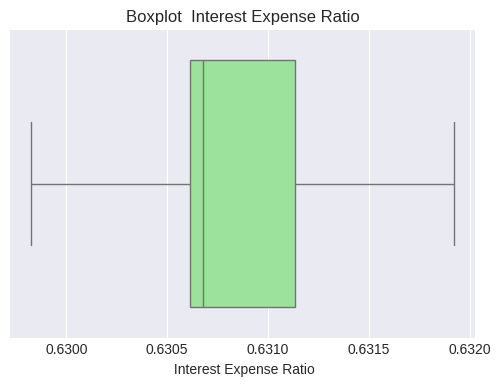

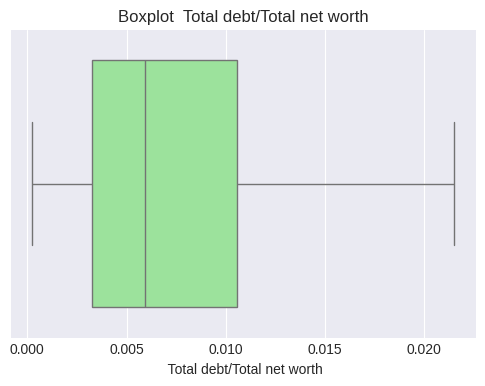

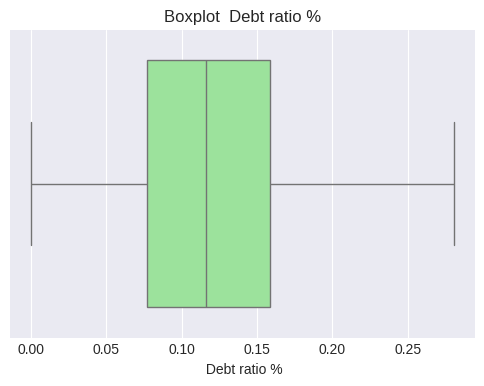

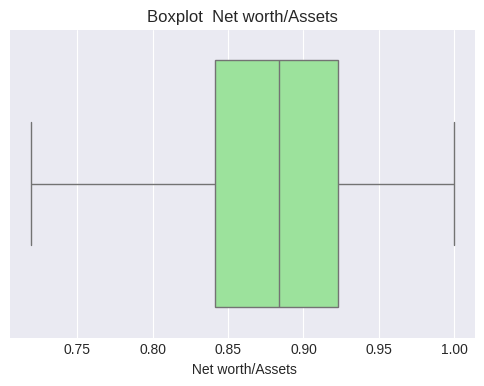

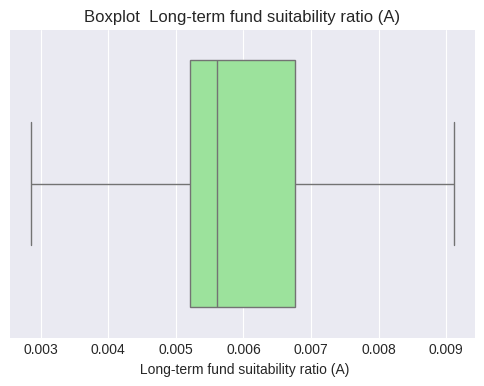

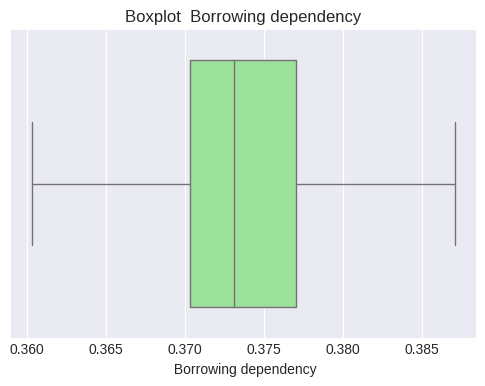

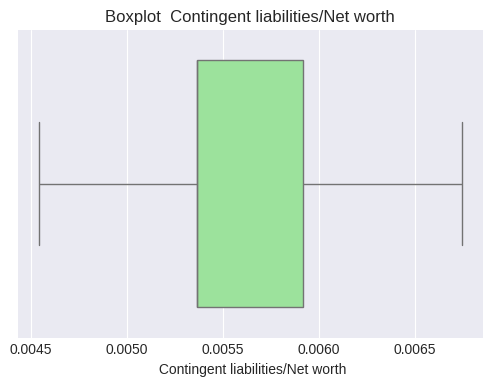

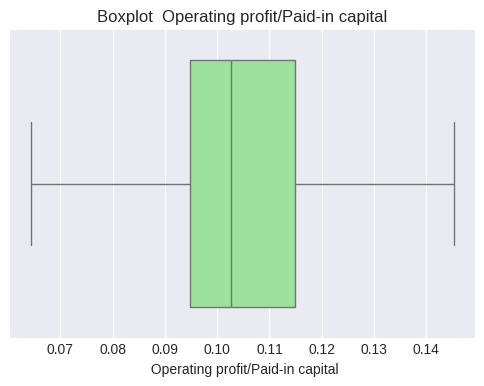

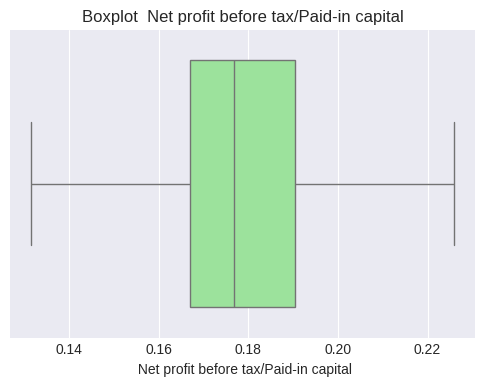

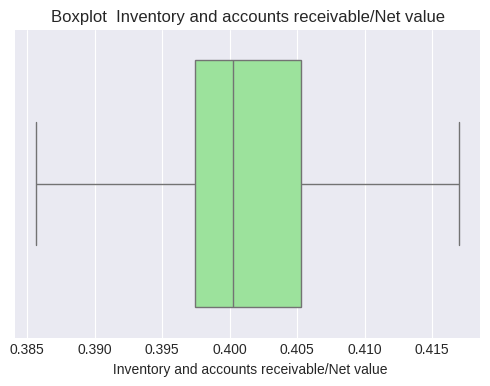

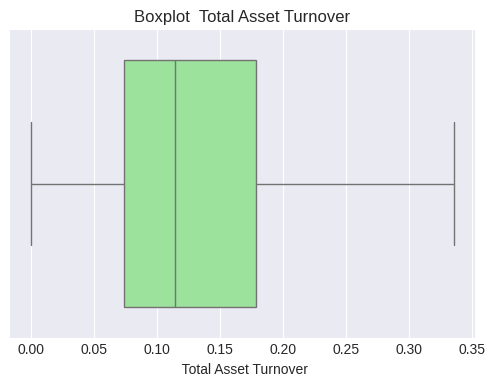

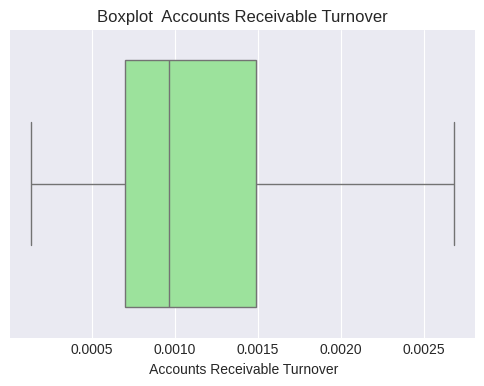

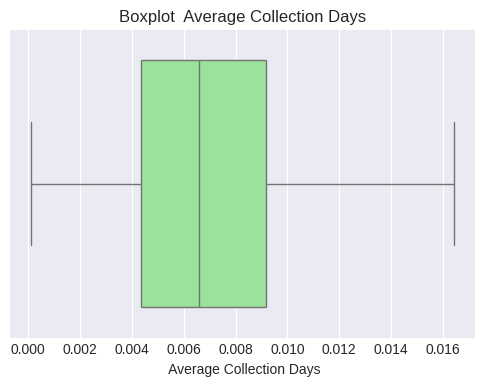

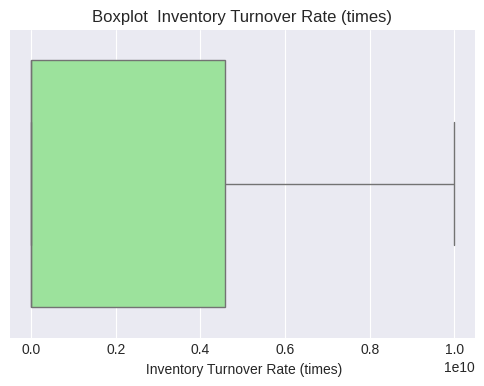

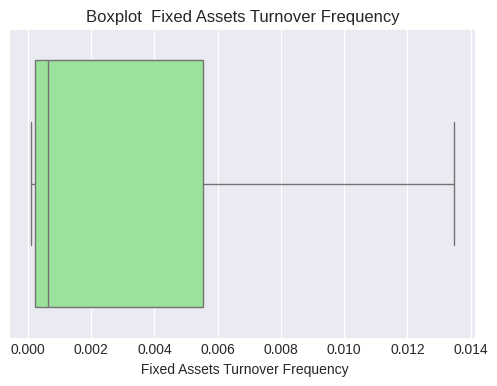

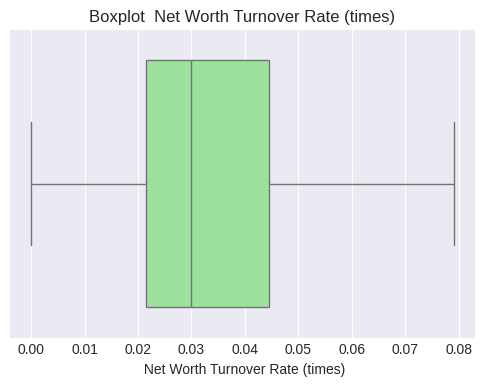

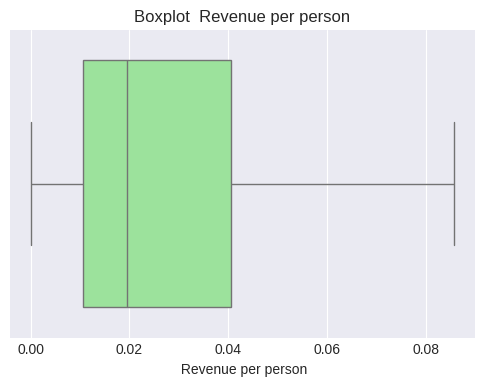

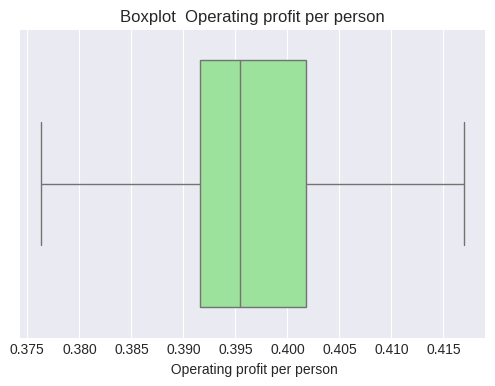

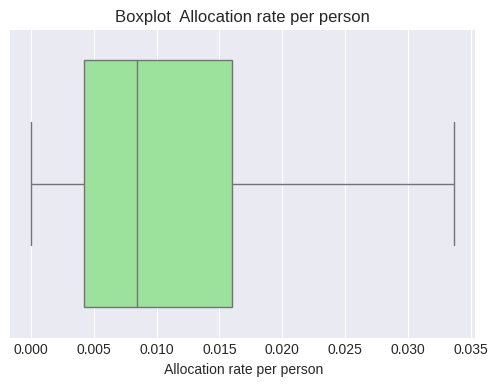

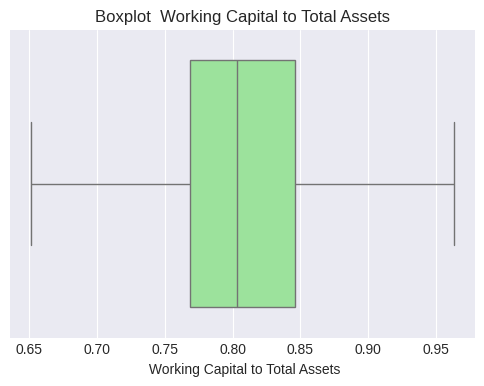

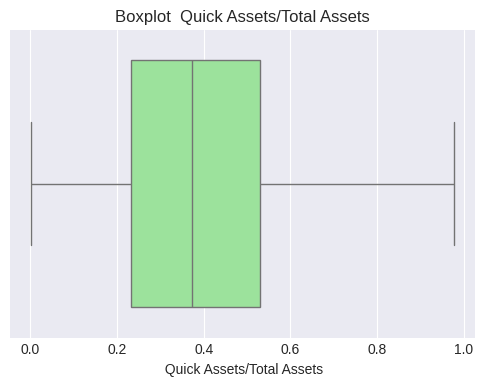

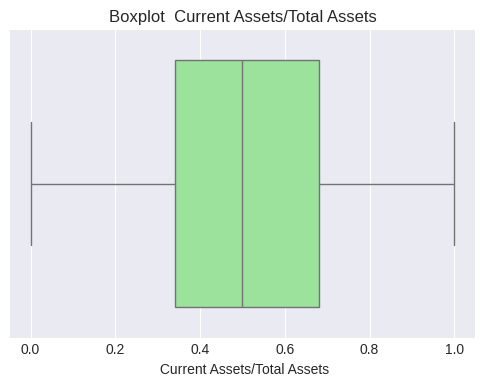

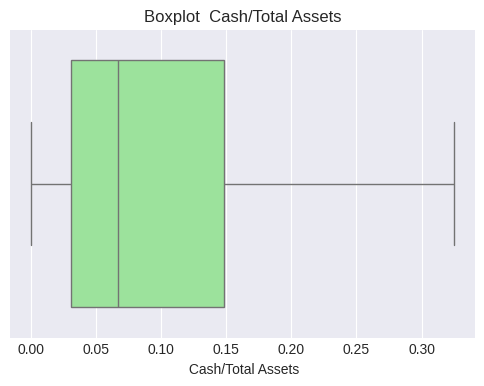

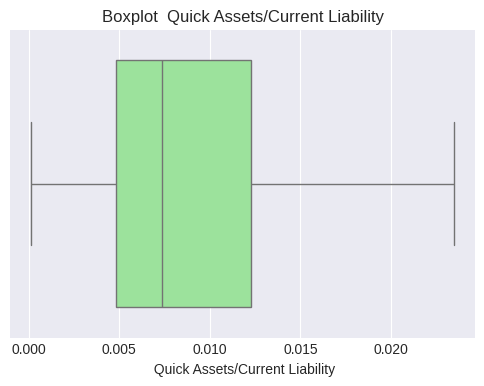

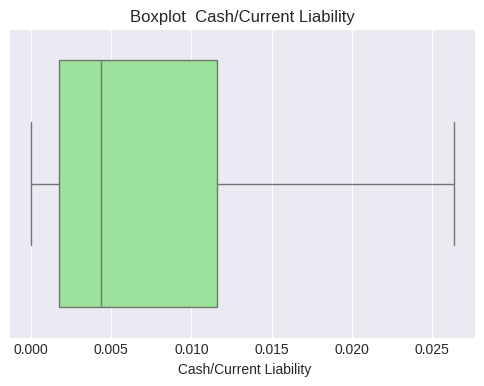

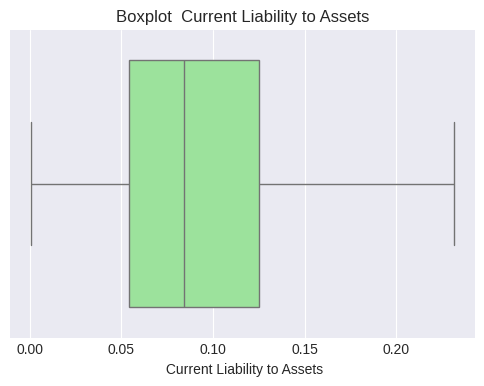

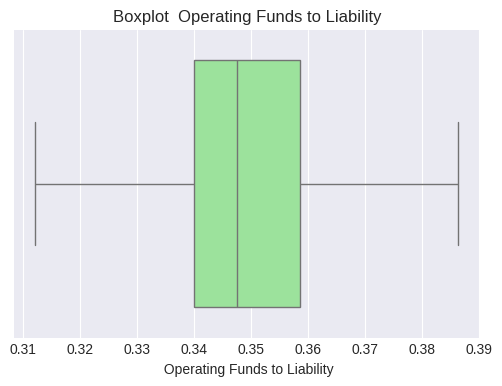

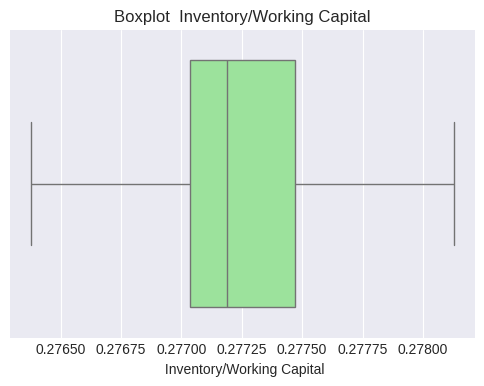

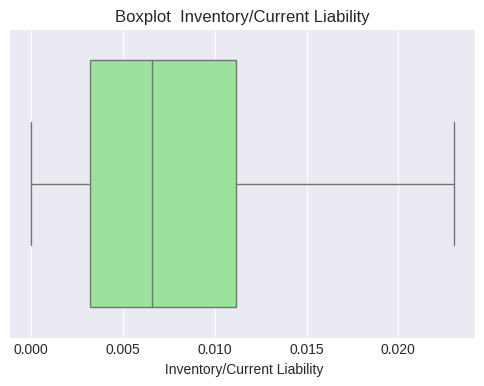

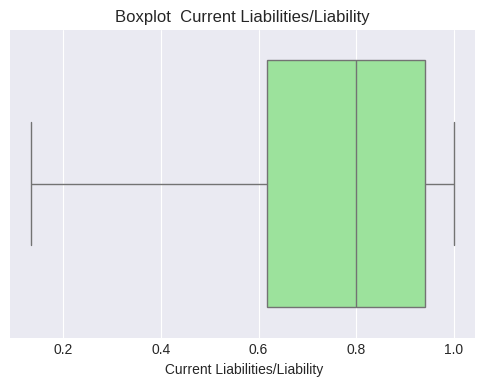

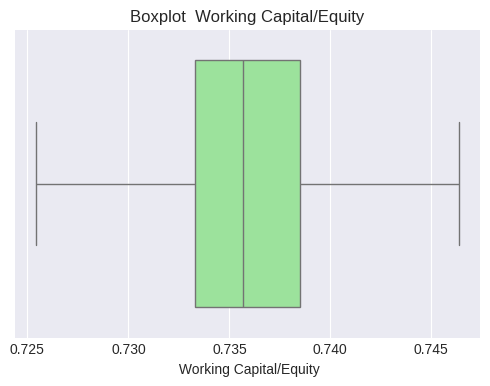

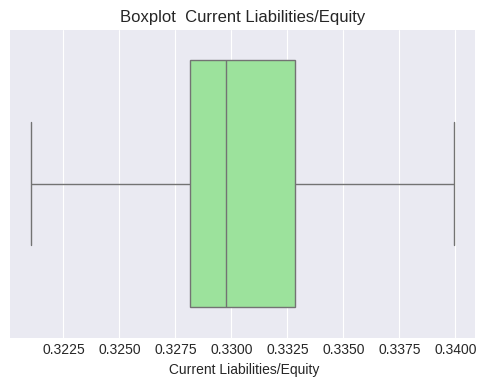

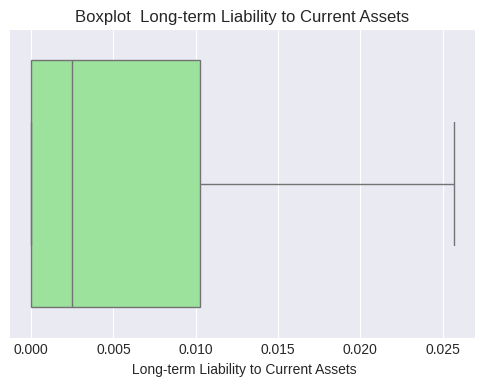

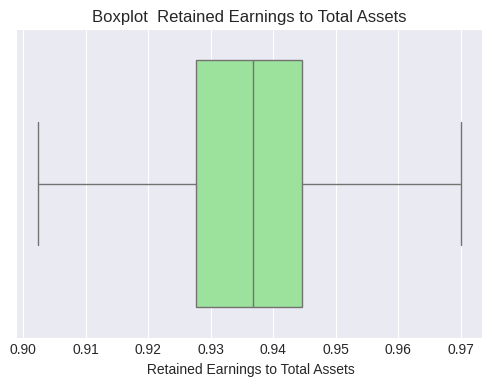

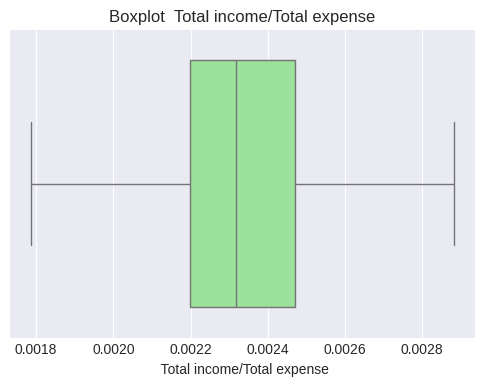

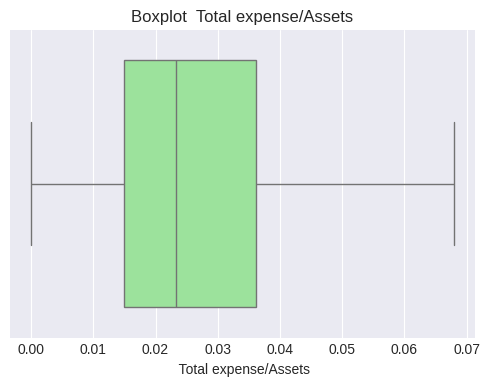

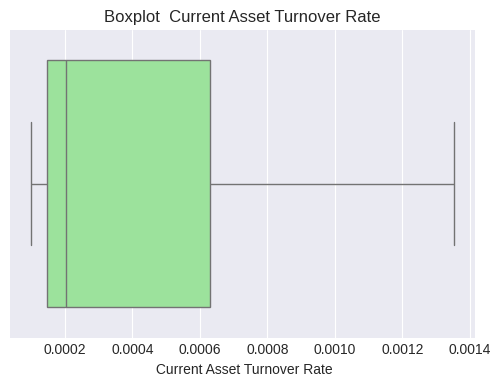

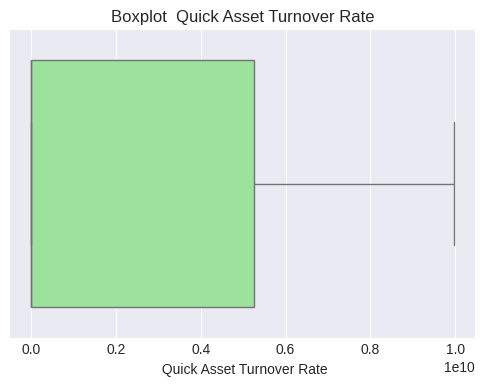

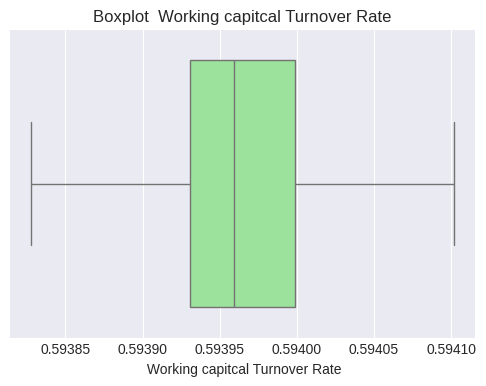

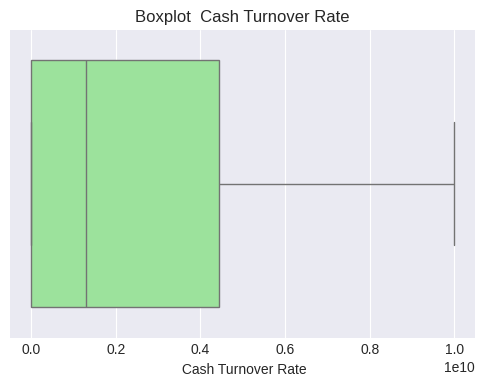

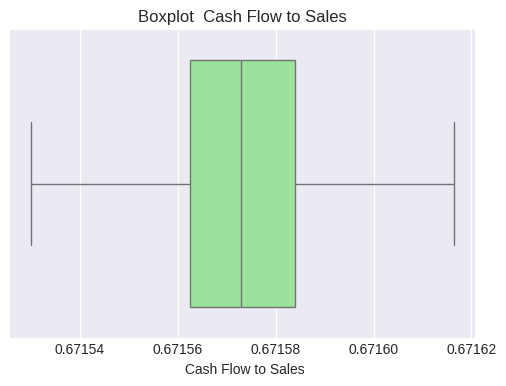

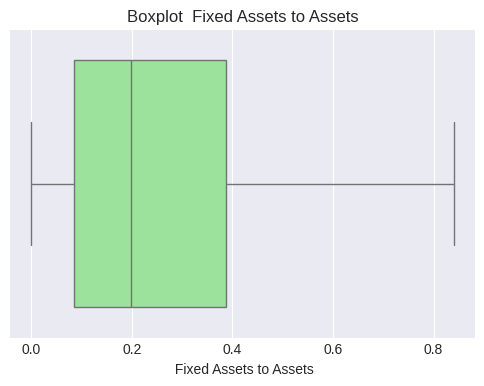

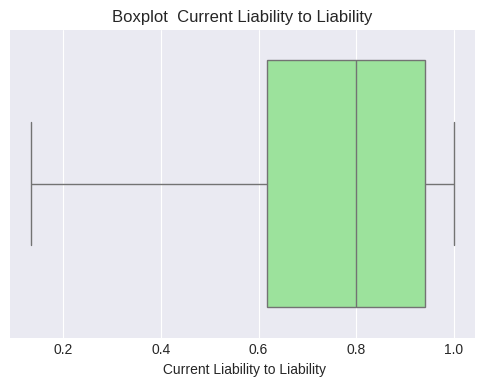

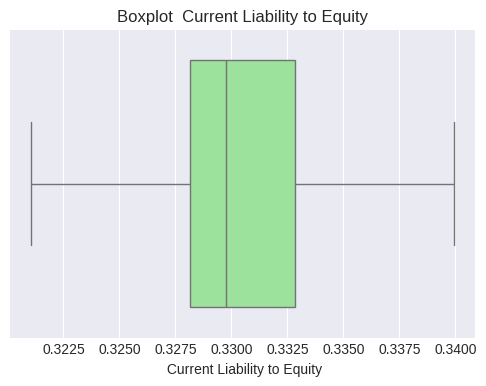

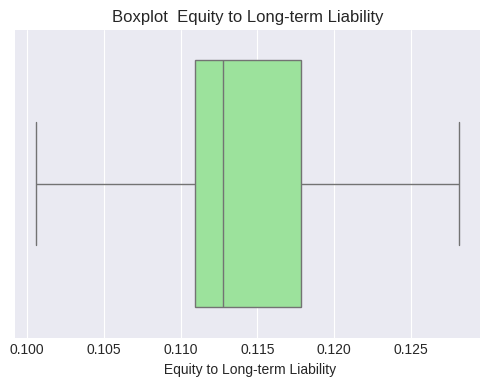

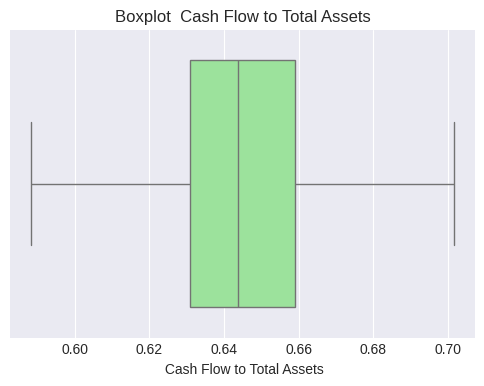

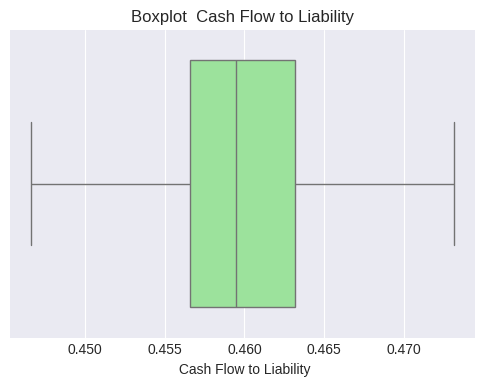

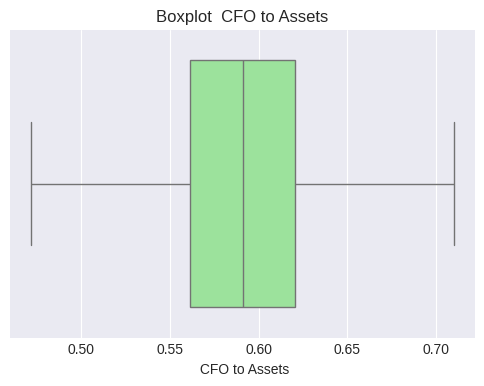

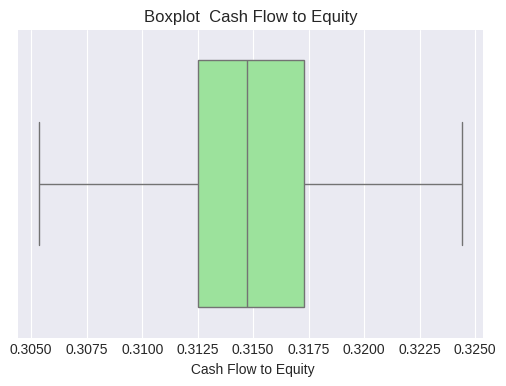

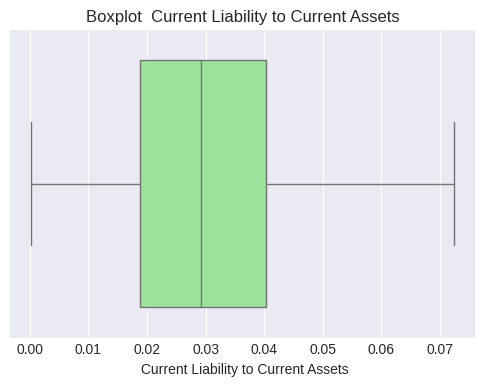

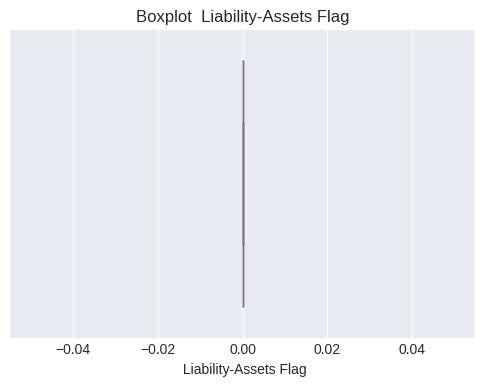

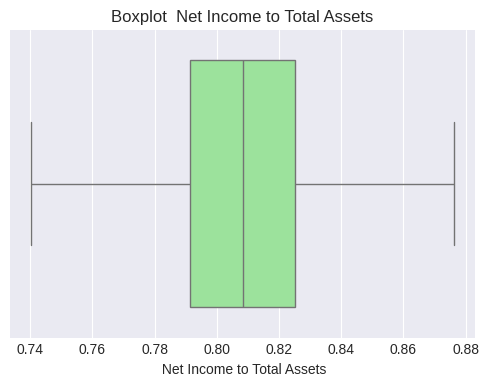

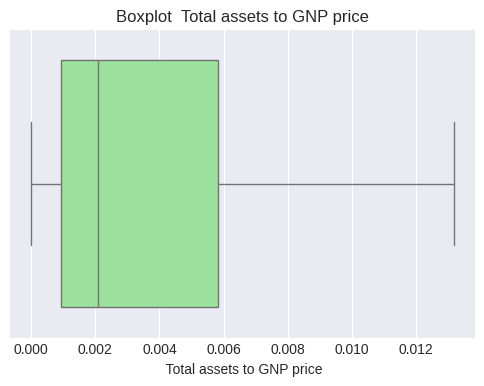

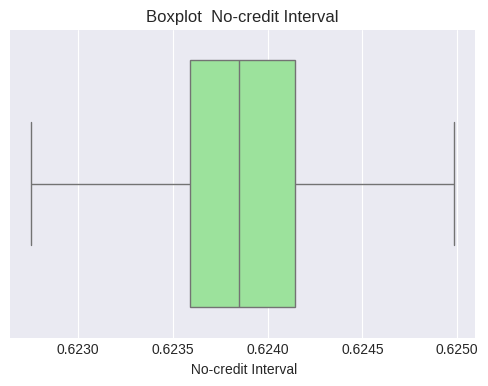

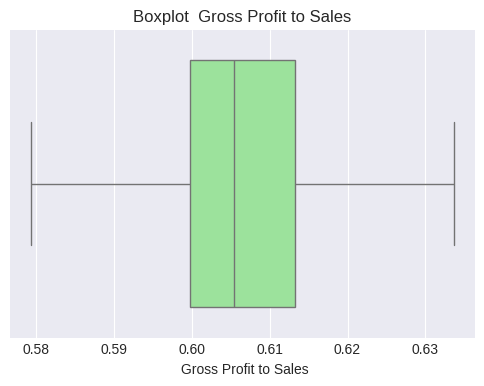

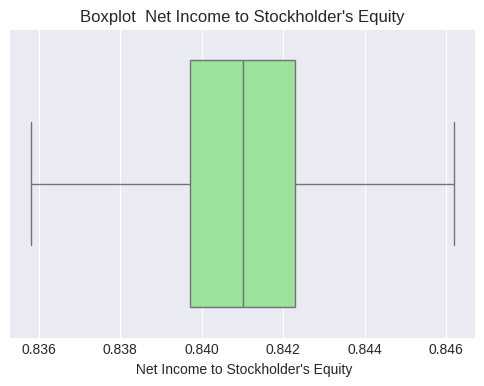

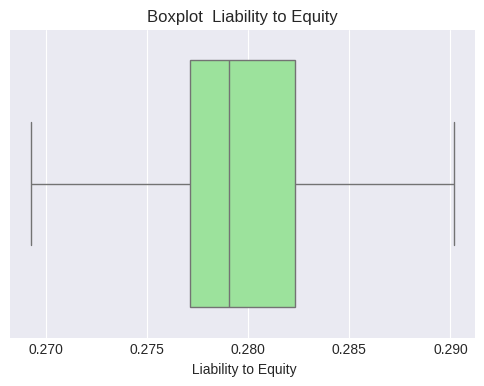

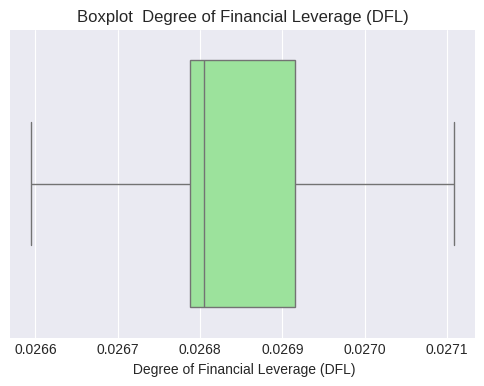

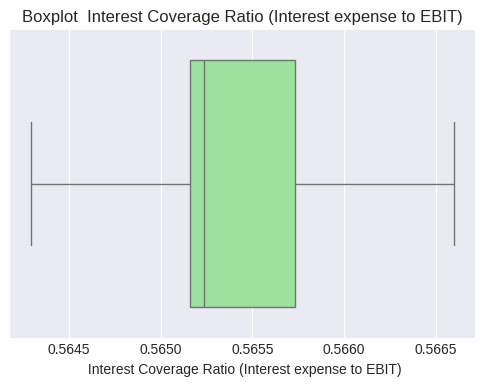

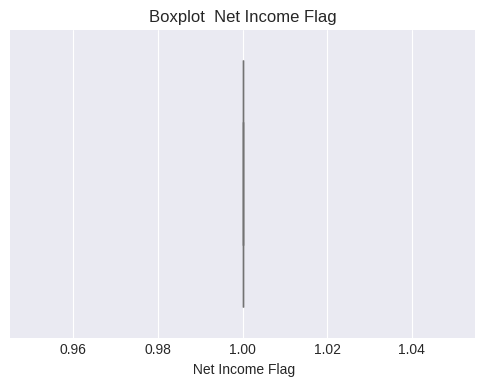

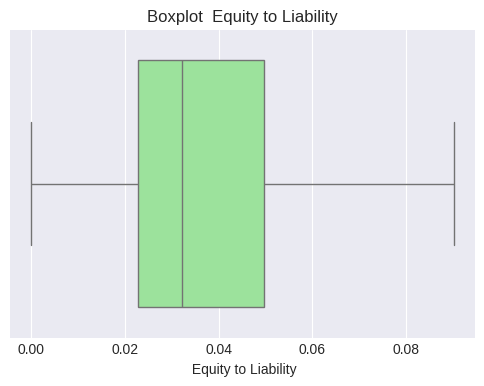

In [77]:
#Cek outlier dengan menggunakan boxplot
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=X_train[col], color="lightgreen")
    plt.title(f"Boxplot {col}")
    plt.show()

## Feature Selection

   ✅ Feature Selection: Top 20 features dipilih


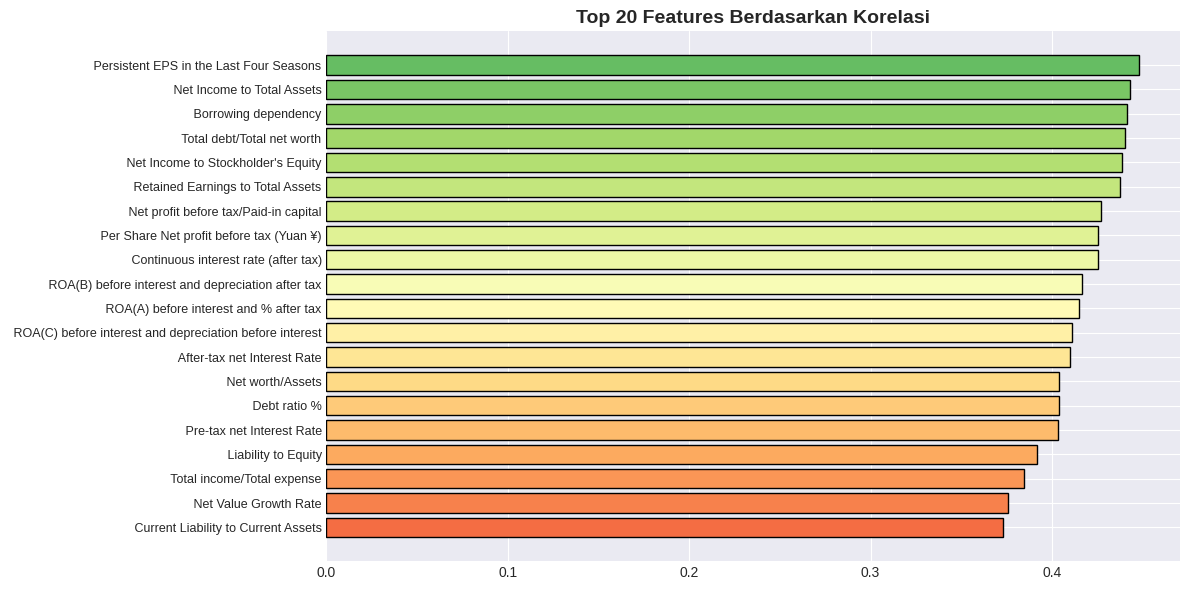

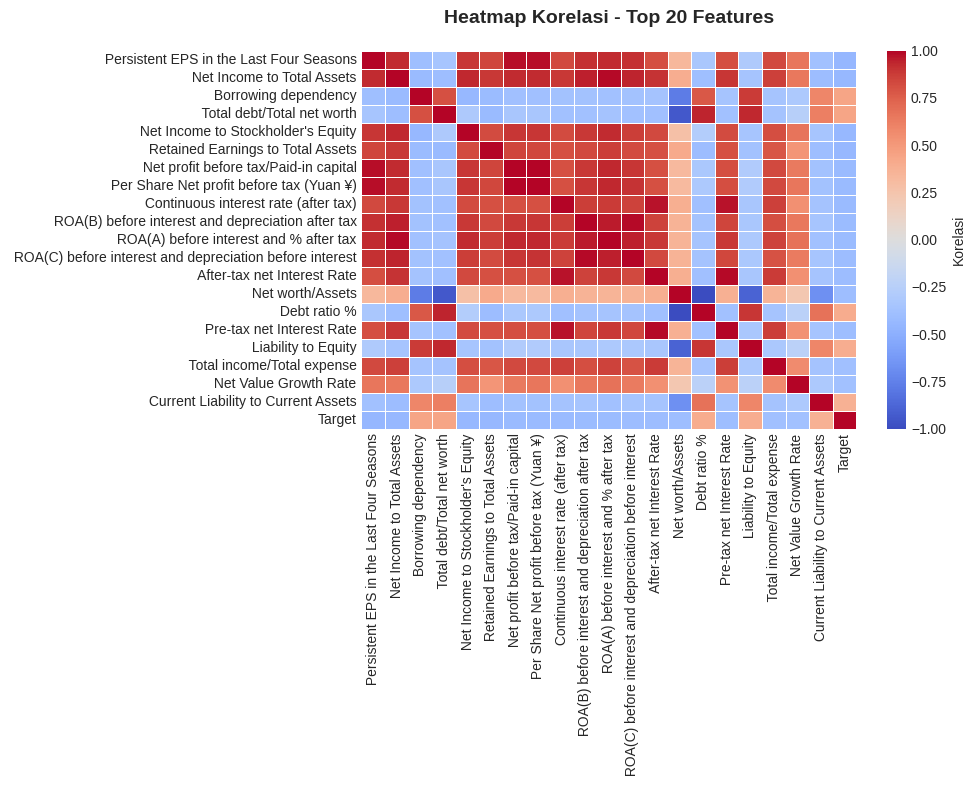

In [78]:
# Hitung korelasi
df_corr = X_train_df.copy()
df_corr['Target'] = y_train.values
corr_values = df_corr.corr()['Target'].abs().sort_values(ascending=False)
selected_features = corr_values.iloc[1:21].index.tolist()
print(f"   ✅ Feature Selection: Top 20 features dipilih")

# Visualisasi Feature Importance (Bar Chart)
top_features_val = corr_values.iloc[1:21]
plt.figure(figsize=(12, 6))
colors_imp = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top_features_val)))
plt.barh(range(len(top_features_val)), top_features_val.values, color=colors_imp, edgecolor='black')
plt.yticks(range(len(top_features_val)), top_features_val.index, fontsize=9)
plt.title('Top 20 Features Berdasarkan Korelasi', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Visualisasi Heatmap Korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr[selected_features + ['Target']].corr(),
            annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={'label': 'Korelasi'})
plt.title('Heatmap Korelasi - Top 20 Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Filter dataset dengan fitur terpilih
X_train_final = X_train_df[selected_features]
X_val_final = X_val_df[selected_features]
X_test_final = X_test_df[selected_features]

Dalam penelitian ini, seleksi fitur dilakukan menggunakan metode Filter-based Feature Selection berbasis Korelasi Pearson. Langkah ini bertujuan untuk mengidentifikasi indikator keuangan yang memiliki hubungan linear paling kuat dengan status kebangkrutan.

Sehingga features yang dipilih adalah:
1. Net Income to Total Assets
2. Borrowing dependency
3. Total debt/Total net worth
4. Net Income to Stockholder's Equity
5. Retained Earnings to Total Assets
6. Net profit before tax/Paid-in capital
7. Per Share Net profit before tax (Yuan ¥)
8. Continuous interest rate (after tax)
9. ROA(B) before interest and depreciation after tax
10. ROA(A) before interest and % after tax
11. ROA(C) before interest and depreciation before interest
12. After-tax net Interest Rate
13. Net worth/Assets
14. Debt ratio %
15. Pre-tax net Interest Rate
16. Liability to Equity
17. Total income/Total expense
18. Net Value Growth Rate19
19. Current Liability to Current Assets
20. Persistent EPS in the Last Four Seasons

## Handling Imbalance - Train Set

   Sebelum Sampling: {0: np.int64(1424), 1: np.int64(176)}
   Setelah Sampling: {0: np.int64(704), 1: np.int64(704)}
   Setelah Sampling: {0: np.int64(704), 1: np.int64(704)}


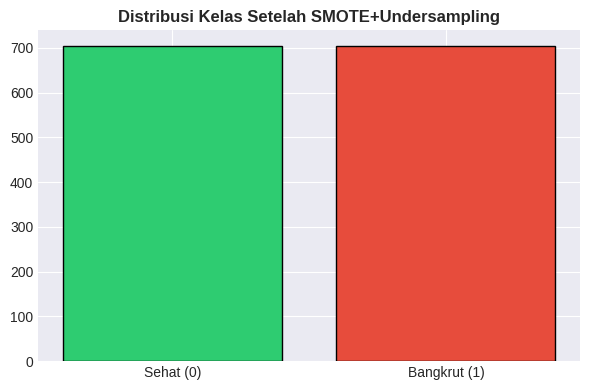

In [79]:
print(f"   Sebelum Sampling: {dict(y_train.value_counts())}")

# 1. Undersample mayoritas
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
over = SMOTE(sampling_strategy='auto', random_state=42)

X_train_under, y_train_under = under.fit_resample(X_train_final, y_train)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_under, y_train_under)

print(f"   Setelah Sampling: {dict(y_train_resampled.value_counts())}")
# 2. SMOTE minoritas
under = RandomUnderSampler(sampling_strategy=0.25, random_state=42)
over = SMOTE(sampling_strategy='auto', random_state=42)

X_train_under, y_train_under = under.fit_resample(X_train_final, y_train)
X_train_resampled, y_train_resampled = over.fit_resample(X_train_under, y_train_under)

print(f"   Setelah Sampling: {dict(y_train_resampled.value_counts())}")

# Visualisasi Hasil Sampling
fig, ax = plt.subplots(figsize=(6, 4))
counts_resampled = y_train_resampled.value_counts()
ax.bar(['Sehat (0)', 'Bangkrut (1)'], counts_resampled.values,
       color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax.set_title("Distribusi Kelas Setelah SMOTE+Undersampling", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Tahap ini akan diterapkan pada data training untuk mencegah kebocoran data, artinya data uji akan tetap murni tanpa adanya proses penambahan/pengurangan. Maka dari itu diperlukan teknik khusus menangani tantangan tersebut.  

Pada tahap ini akan diterapkan hybrid sampling, di sini teknik yang digunakan pertama kali adalah undersampling dengan random undersampling. Data mayoritas dalam hal ini data sehat akan dipangkas sebesar 0,25 dari data bangkrut(1). Data bangkrut sebelum undersampling adalah 176/0,25 = 704.

Setelah itu, data bangkrut akan di oversampling hingga mencapai angka 704. Dengan hal ini, data yang dilatih akan balance dan mesin tidak akan berfokus kepada data mayoritas.

## Model Training dan Validasi

Untuk memastikan evaluasi yang objektif dan adil (fair comparison), penelitian ini tidak hanya menggunakan parameter bawaan (default) dari setiap algoritma. Tahap pelatihan dilakukan bersamaan dengan Hyperparameter Tuning menggunakan metode Grid Search Cross-Validation (GridSearchCV).

Tujuannya adalah untuk mengeksplorasi ruang parameter (search space) dan menemukan konfigurasi optimal bagi masing-masing model (Logistic Regression, Random Forest, SVM, KNN, dan LightGBM). Dengan cara ini, perbandingan kinerja antar-algoritma dilakukan pada kondisi performa terbaiknya masing-masing (best-case scenario), bukan pada kondisi default yang mungkin kurang optimal.

In [80]:
print("TRAINING DENGAN HYPERPARAMETER TUNING (MENCARI MODEL TERBAIK)...")
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 2, 4]
    },
    "SVM": {
        'C': [1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "LightGBM": {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 50]
    }
}

# 2. Inisialisasi Model Dasar
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "SVM": SVC(random_state=42, class_weight='balanced', probability=True),
    "KNN": KNeighborsClassifier(),
    "LightGBM": LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)
}

results = []
trained_models = {} # Menyimpan model versi 'tuned' terbaik

# 3. Loop Training + Tuning
for name, model in models.items():
    print(f"\n🔍 Sedang Tuning & Training: {name}...")

    if name in param_grids:
        grid = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=3,
            scoring='f1', # menggunakan 'f1' agar seimbang
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train_resampled, y_train_resampled)

        # Ambil model terbaik hasil tuning
        best_model = grid.best_estimator_
        print(f"   ✅ Best Params: {grid.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_resampled, y_train_resampled)

    trained_models[name] = best_model

    # 4. Evaluasi ke Validation Set
    y_pred_val = best_model.predict(X_val_final)

    results.append({
        'Model': name,
        'Recall': recall_score(y_val, y_pred_val),
        'Precision': precision_score(y_val, y_pred_val),
        'F1-Score': f1_score(y_val, y_pred_val),
        'Accuracy': accuracy_score(y_val, y_pred_val)
    })

# Tampilkan Hasil
results_df = pd.DataFrame(results)
print("\n📋 HASIL VALIDASI (SETELAH SEMUA DI-TUNING):")
print(results_df.sort_values(by='F1-Score', ascending=False).to_string(index=False))

TRAINING DENGAN HYPERPARAMETER TUNING (MENCARI MODEL TERBAIK)...

🔍 Sedang Tuning & Training: Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
   ✅ Best Params: {'C': 10, 'solver': 'liblinear'}

🔍 Sedang Tuning & Training: Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
   ✅ Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}

🔍 Sedang Tuning & Training: SVM...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
   ✅ Best Params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

🔍 Sedang Tuning & Training: KNN...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
   ✅ Best Params: {'n_neighbors': 3, 'weights': 'distance'}

🔍 Sedang Tuning & Training: LightGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
   ✅ Best Params: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}

📋 HASIL VALIDASI (SETELAH SEMUA DI-TUNING):
              Model   Recall  Precision  F1-S

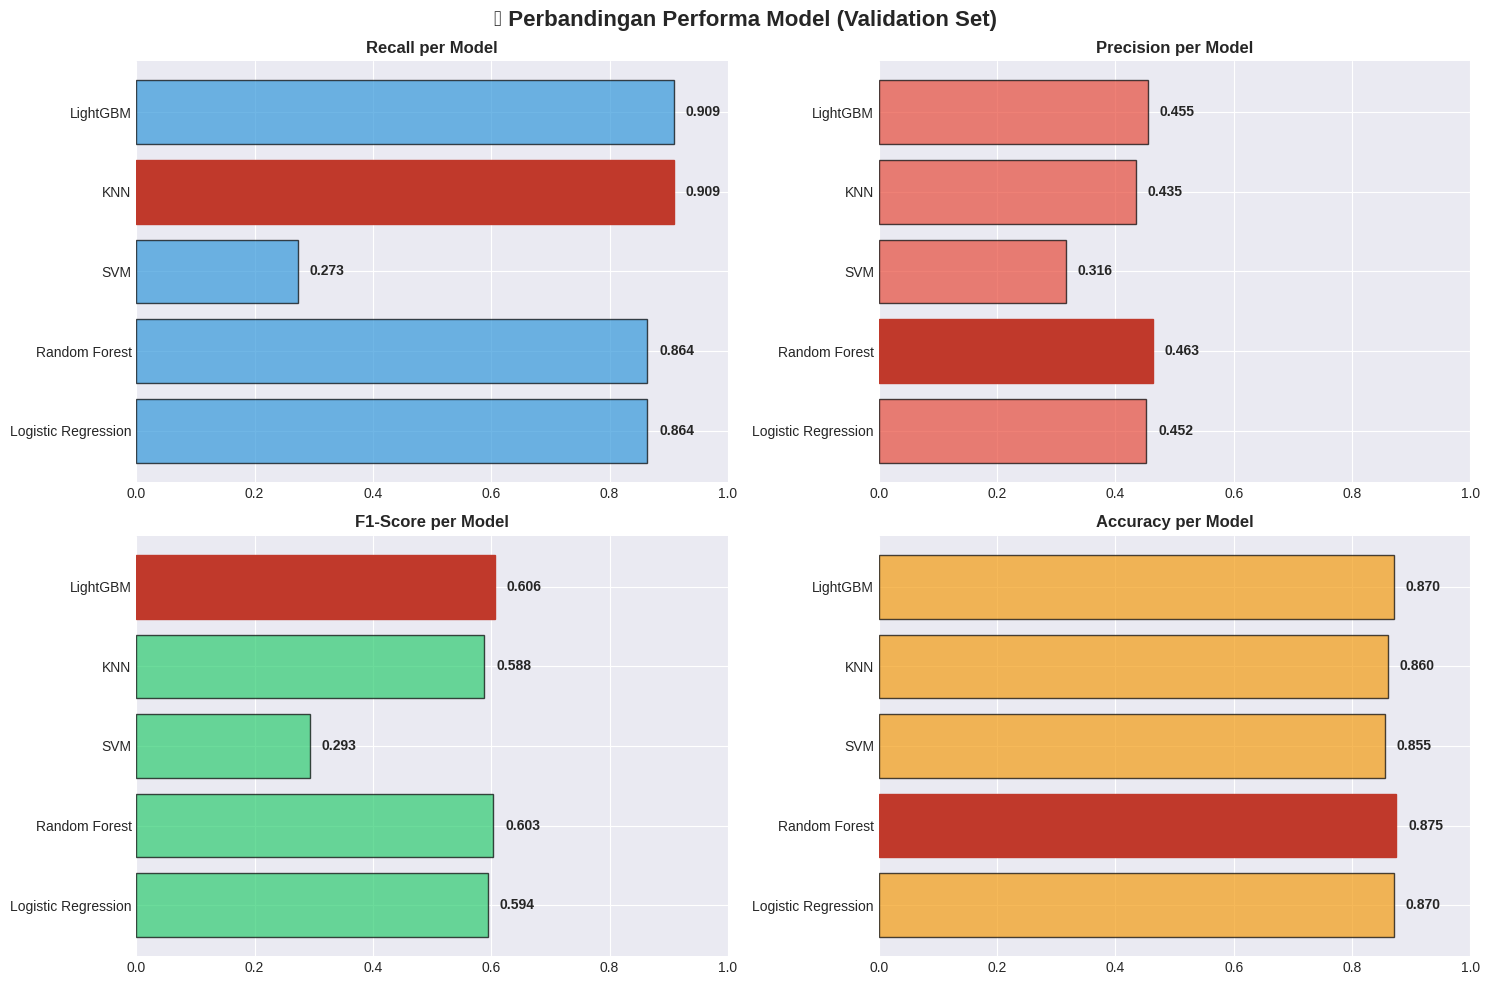

In [81]:
# VISUALISASI PERBANDINGAN MODEL
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_list = ['Recall', 'Precision', 'F1-Score', 'Accuracy']
colors_list = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (ax, metric, color) in enumerate(zip(axes.flatten(), metrics_list, colors_list)):
    values = results_df[metric].values
    bars = ax.barh(results_df['Model'], values, color=color, alpha=0.7, edgecolor='black')

    # Highlight nilai tertinggi
    best_idx_metric = np.argmax(values)
    bars[best_idx_metric].set_color('#c0392b')
    bars[best_idx_metric].set_alpha(1)

    ax.set_xlim(0, 1)
    ax.set_title(f'{metric} per Model', fontsize=12, fontweight='bold')
    for i, v in enumerate(values):
        ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

plt.suptitle('📊 Perbandingan Performa Model (Validation Set)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


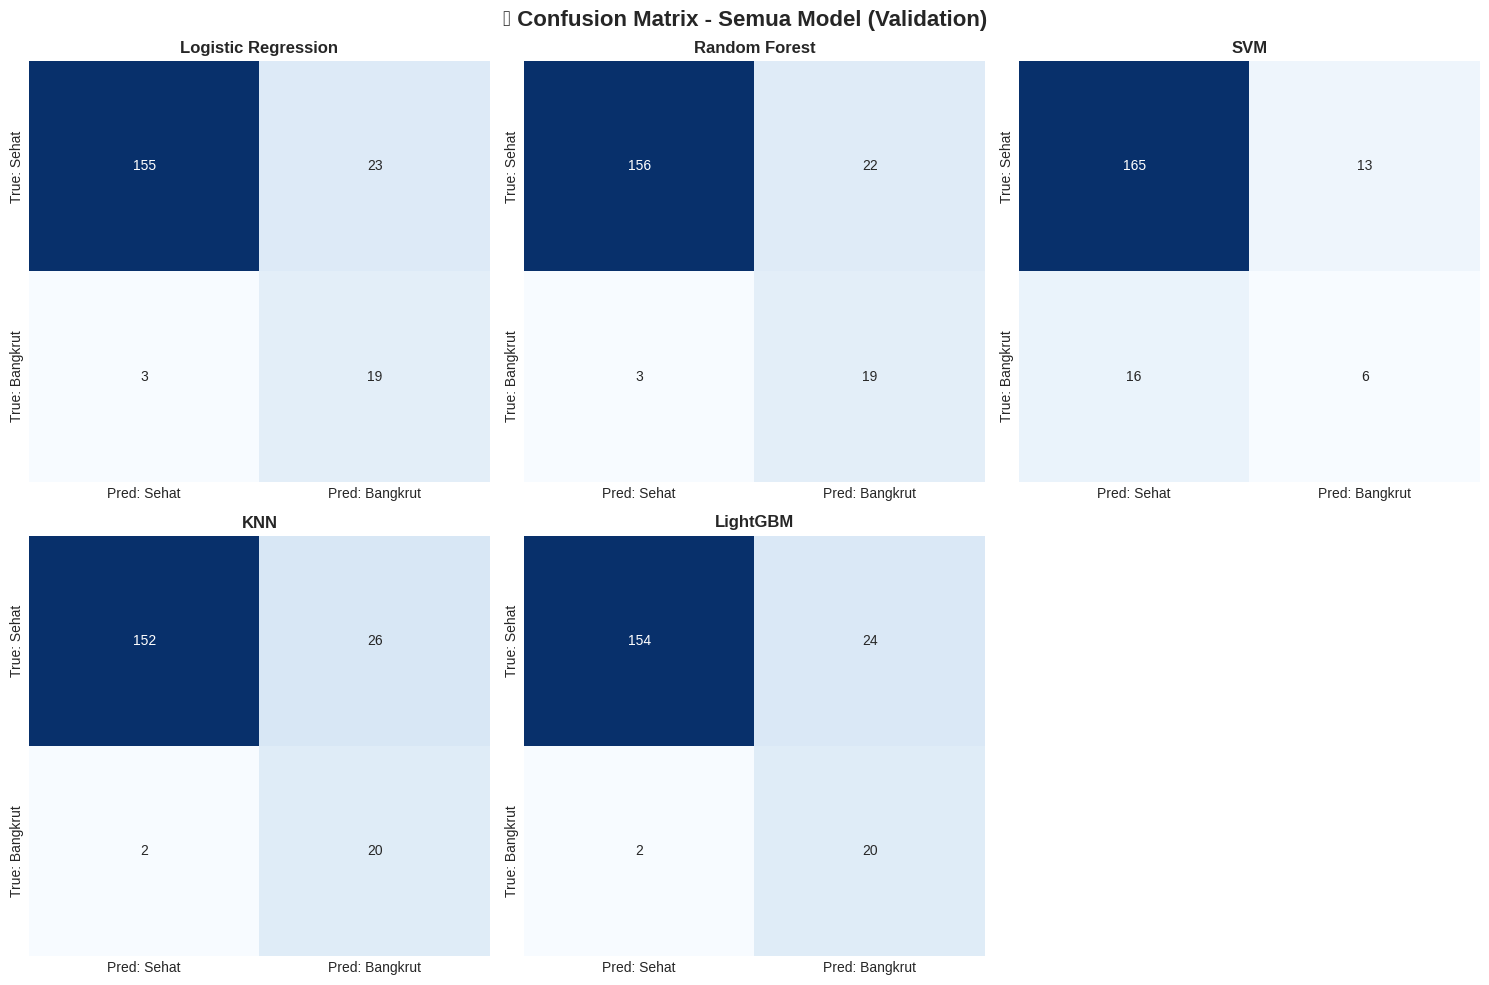

In [82]:
# VISUALISASI CONFUSION MATRIX SEMUA MODEL
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_val_final)
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx],
                xticklabels=['Pred: Sehat', 'Pred: Bangkrut'],
                yticklabels=['True: Sehat', 'True: Bangkrut'])
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')

if len(trained_models) < len(axes): axes[-1].axis('off')
plt.suptitle('🎯 Confusion Matrix - Semua Model (Validation)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Model Terbaik

In [83]:
print("Screening Kandidat (Berdasarkan Hasil Validasi)")
top_3_models = results_df.sort_values(by='F1-Score', ascending=False).head(3)
print(top_3_models[['Model', 'Recall', 'Precision', 'F1-Score', 'Accuracy']].to_string(index=False))


Screening Kandidat (Berdasarkan Hasil Validasi)
              Model   Recall  Precision  F1-Score  Accuracy
           LightGBM 0.909091   0.454545  0.606061     0.870
      Random Forest 0.863636   0.463415  0.603175     0.875
Logistic Regression 0.863636   0.452381  0.593750     0.870


Sebagai langkah awal dalam penentuan model terbaik, dilakukan proses penyaringan (screening) terhadap seluruh algoritma yang telah dilatih. Tabel di bawah ini menyajikan tiga model kandidat terbaik (Top-3 Models) yang diurutkan berdasarkan nilai F1-Score pada tahap validasi.

Penggunaan F1-Score sebagai metrik pemeringkatan utama bertujuan untuk memastikan bahwa model kandidat memiliki keseimbangan yang baik antara kemampuan mendeteksi kelas minoritas (Recall) dan ketepatan prediksi (Precision), sebelum dilakukan evaluasi lebih lanjut terkait stabilitas model.

## Testing

In [84]:
stability_results = []

for name in top_3_models['Model'].values:
    model = trained_models[name]

    # Hitung SEMUA metrik di Test Set
    y_pred_test_temp = model.predict(X_test_final)

    recall_test = recall_score(y_test, y_pred_test_temp)
    precision_test = precision_score(y_test, y_pred_test_temp)
    f1_test = f1_score(y_test, y_pred_test_temp)
    accuracy_test = (y_pred_test_temp == y_test).mean()

    # Ambil metrik dari Validasi
    recall_val = results_df[results_df['Model'] == name]['Recall'].values[0]
    precision_val = results_df[results_df['Model'] == name]['Precision'].values[0]
    f1_val = results_df[results_df['Model'] == name]['F1-Score'].values[0]
    accuracy_val = results_df[results_df['Model'] == name]['Accuracy'].values[0]

    # Hitung Gap untuk setiap metrik
    recall_gap = recall_test - recall_val
    precision_gap = precision_test - precision_val
    f1_gap = f1_test - f1_val
    accuracy_gap = accuracy_test - accuracy_val

    # Hitung Average Absolute Gap (Stability Score)
    avg_gap = abs(recall_gap) + abs(precision_gap) + abs(f1_gap) + abs(accuracy_gap)
    avg_gap = avg_gap / 4

    # Status Stabilitas
    if avg_gap < 0.03:
        status = "✅ SANGAT STABIL"
    elif avg_gap < 0.05:
        status = "✅ STABIL"
    elif avg_gap < 0.10:
        status = "⚠️ CUKUP STABIL"
    else:
        status = "❌ TIDAK STABIL"

    stability_results.append({
        'Model': name,
        'Recall_Val': recall_val,
        'Recall_Test': recall_test,
        'Recall_Gap': recall_gap,
        'Precision_Val': precision_val,
        'Precision_Test': precision_test,
        'Precision_Gap': precision_gap,
        'F1_Val': f1_val,
        'F1_Test': f1_test,
        'F1_Gap': f1_gap,
        'Accuracy_Val': accuracy_val,
        'Accuracy_Test': accuracy_test,
        'Accuracy_Gap': accuracy_gap,
        'Avg_Gap': avg_gap,
        'Status': status
    })

# Tampilkan Hasil dalam Tabel
stability_df = pd.DataFrame(stability_results)

print("\n Tabel Performa Validation vs Testing\n")
print(f"{'Model':<20} | {'Recall':<18} | {'Precision':<18} | {'F1-Score':<18} | {'Accuracy':<18}")
print(f"{'':20} | {'Val':<8} {'Test':<8} | {'Val':<8} {'Test':<8} | {'Val':<8} {'Test':<8} | {'Val':<8} {'Test':<8}")
print("-" * 110)

for _, row in stability_df.iterrows():
    print(f"{row['Model']:<20} | {row['Recall_Val']:.4f}   {row['Recall_Test']:.4f}  | "
          f"{row['Precision_Val']:.4f}   {row['Precision_Test']:.4f}  | "
          f"{row['F1_Val']:.4f}   {row['F1_Test']:.4f}  | "
          f"{row['Accuracy_Val']:.4f}   {row['Accuracy_Test']:.4f}")



 Tabel Performa Validation vs Testing

Model                | Recall             | Precision          | F1-Score           | Accuracy          
                     | Val      Test     | Val      Test     | Val      Test     | Val      Test    
--------------------------------------------------------------------------------------------------------------
LightGBM             | 0.9091   0.7273  | 0.4545   0.4324  | 0.6061   0.5424  | 0.8700   0.8650
Random Forest        | 0.8636   0.7273  | 0.4634   0.4444  | 0.6032   0.5517  | 0.8750   0.8700
Logistic Regression  | 0.8636   0.8636  | 0.4524   0.4318  | 0.5938   0.5758  | 0.8700   0.8600


Tabel ini menyajikan evaluasi stabilitas model dengan membandingkan metrik performa antara data validasi (training phase) dan data testing (unseen data). Analisis ini krusial untuk mendeteksi indikasi overfitting atau ketidakmampuan model dalam menggeneralisasi pola pada data baru.

## Evaluasi


📉 TABEL 2: Gap Analysis (Test - Validation)
Model                | Recall Gap   | Precision Gap  | F1 Gap       | Accuracy Gap   | Avg Gap    | Status
------------------------------------------------------------------------------------------------------------------------
LightGBM             | 📉 -0.1818    | 📉 -0.0221      | 📉 -0.0637    | 📉 -0.0050       | 0.0682     | ⚠️ CUKUP STABIL
Random Forest        | 📉 -0.1364    | 📉 -0.0190      | 📉 -0.0515    | 📉 -0.0050       | 0.0529     | ⚠️ CUKUP STABIL
Logistic Regression  | 📉 +0.0000    | 📉 -0.0206      | 📉 -0.0180    | 📉 -0.0100       | 0.0121     | ✅ SANGAT STABIL

Visualisasi Stabilitas


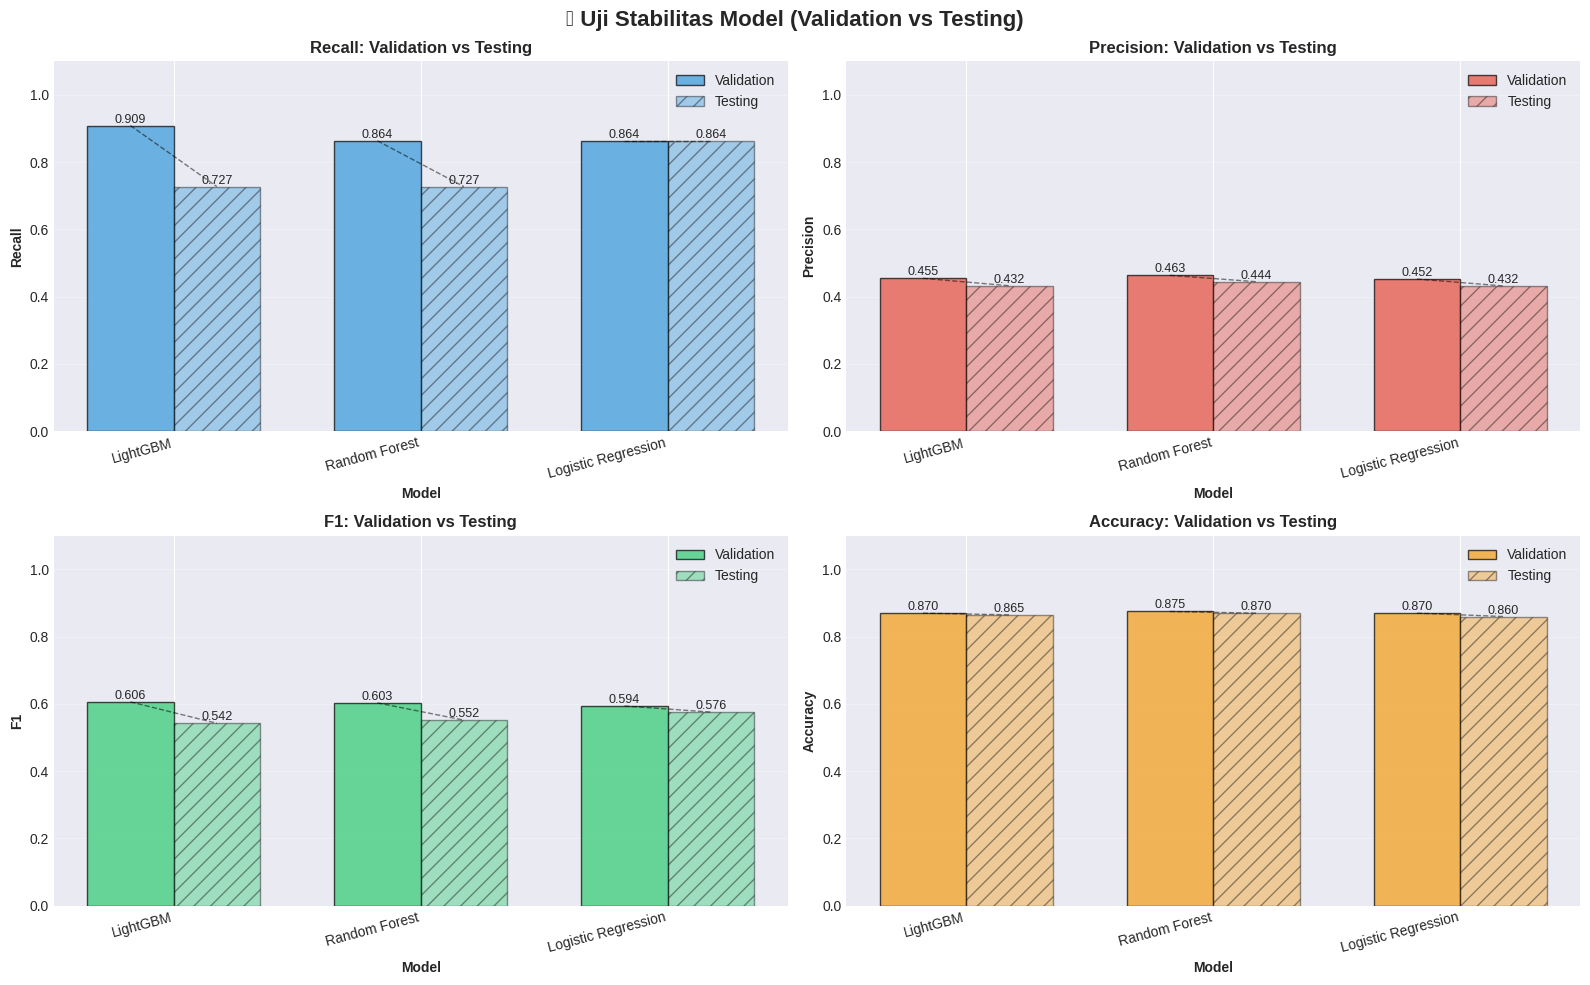

In [85]:
# Tampilkan Gap Analysis
print("\n📉 TABEL 2: Gap Analysis (Test - Validation)")
print(f"{'Model':<20} | {'Recall Gap':<12} | {'Precision Gap':<14} | {'F1 Gap':<12} | {'Accuracy Gap':<14} | {'Avg Gap':<10} | {'Status'}")
print("-" * 120)

for _, row in stability_df.iterrows():
    # Color coding untuk gap
    recall_icon = "📈" if row['Recall_Gap'] > 0 else "📉"
    precision_icon = "📈" if row['Precision_Gap'] > 0 else "📉"
    f1_icon = "📈" if row['F1_Gap'] > 0 else "📉"
    accuracy_icon = "📈" if row['Accuracy_Gap'] > 0 else "📉"

    print(f"{row['Model']:<20} | {recall_icon} {row['Recall_Gap']:+.4f}    | "
          f"{precision_icon} {row['Precision_Gap']:+.4f}      | "
          f"{f1_icon} {row['F1_Gap']:+.4f}    | "
          f"{accuracy_icon} {row['Accuracy_Gap']:+.4f}       | "
          f"{row['Avg_Gap']:.4f}     | {row['Status']}")


print("\nVisualisasi Stabilitas")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

metrics = ['Recall', 'Precision', 'F1', 'Accuracy']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]

    models = stability_df['Model']
    val_col = f"{metric}_Val"
    test_col = f"{metric}_Test"

    x = np.arange(len(models))
    width = 0.35

    # Bar chart Val vs Test
    bars1 = ax.bar(x - width/2, stability_df[val_col], width,
                   label='Validation', color=color, alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, stability_df[test_col], width,
                   label='Testing', color=color, alpha=0.4, edgecolor='black', hatch='//')

    for i in range(len(models)):
        ax.plot([i - width/2, i + width/2],
                [stability_df[val_col].iloc[i], stability_df[test_col].iloc[i]],
                'k--', alpha=0.5, linewidth=1)

    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    ax.set_xlabel('Model', fontweight='bold')
    ax.set_ylabel(metric, fontweight='bold')
    ax.set_title(f'{metric}: Validation vs Testing', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('📊 Uji Stabilitas Model (Validation vs Testing)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Berdasarkan gambar tersebut, terlihat fenomena yang kontras antara model berbasis tree (LightGBM dan Random Forest) dengan model linear (Logistic Regression):

1. LightGBM & Random Forest (Indikasi Overfitting): Meskipun LightGBM mencatatkan Recall validasi tertinggi (0.9091), performanya mengalami penurunan drastis pada fase testing menjadi 0.7273. Penurunan sebesar ~18% ini mengindikasikan bahwa model cenderung menghafal data latih (overfitting) dan gagal menangkap pola general pada data uji. Hal serupa terjadi pada Random Forest yang juga mengalami penurunan Recall signifikan ke angka 0.7273.

2. Logistic Regression (Stabilitas Tinggi): Sebaliknya, Logistic Regression menunjukkan konsistensi yang luar biasa. Nilai Recall pada fase validasi dan testing bertahan di angka yang sama persis, yaitu 0.8636. Selain itu, selisih (gap) pada metrik Precision, F1-Score, dan Accuracy juga sangat minim (< 0.02).

Temuan ini mengonfirmasi bahwa Logistic Regression adalah model yang paling robust (tahan banting). Dalam konteks deteksi kebangkrutan, stabilitas Recall (kemampuan mendeteksi risiko) jauh lebih berharga daripada skor validasi tinggi yang tidak terbukti saat pengujian nyata.